# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [5]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

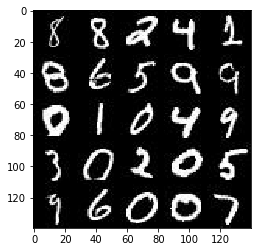

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

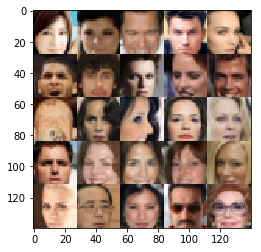

In [7]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


/home/sergiocncruz/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [10]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_images_input = tf.placeholder(dtype=tf.float32, shape=(
                                                                None, 
                                                                image_width, 
                                                                image_height, 
                                                                image_channels
                                                               ),
                                       name='real_images_input'
                                      )
    zdata_input = tf.placeholder(dtype=tf.float32,shape=(None, z_dim), name='zdata_input')
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')

    return (real_images_input, zdata_input, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/sergiocncruz/anaconda3/lib/python3.5/runpy.py", line 170, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/sergiocncruz/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/sergiocncruz/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/sergiocncruz/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/sergiocncruz/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/sergiocncruz/anaconda3/lib/p

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [12]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        a = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        a = tf.maximum(alpha * a, a)
        
        b = tf.layers.conv2d(a, 128, 5, strides=2, padding='same')
        b = tf.layers.batch_normalization(b, training=True)
        b = tf.maximum(alpha * b, b)
        
        c = tf.layers.conv2d(b, 256, 5, strides=2, padding='same')
        c = tf.layers.batch_normalization(c, training=True)
        c = tf.maximum(alpha * c, c)

        flat = tf.reshape(c, (-1, 4*4*256))
        dropout_layer = tf.layers.dropout(inputs=flat, rate=0.8)
        logits = tf.layers.dense(dropout_layer, 1)
        output = tf.sigmoid(logits)

    return (output, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse= not is_train):
        a = tf.layers.dense(z, 3*3*512)
        a = tf.reshape(a, (-1, 3, 3, 512))
        a = tf.layers.batch_normalization(a, training=is_train)
        a = tf.maximum(alpha * a, a)
        
        b = tf.layers.conv2d_transpose(a, 256, kernel_size=4, strides=2, padding='same')
        b = tf.layers.batch_normalization(b, training=is_train)
        b = tf.maximum(alpha * b, b)
        
        c = tf.layers.conv2d_transpose(b, 128, kernel_size=4, strides=2, padding='valid')
        c = tf.layers.batch_normalization(c, training=is_train)
        c = tf.maximum(alpha * c, c)
        
        logits = tf.layers.conv2d_transpose(
                                            c, 
                                            out_channel_dim, 
                                            kernel_size=5,
                                            strides=2, 
                                            padding='same'
                                           )
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [24]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    generator_model = generator(input_z, out_channel_dim, is_train=True)
    discriminator_model_real, discriminator_logits_real = discriminator(
                                                                        input_real, 
                                                                        reuse=False 
                                                                       )
    discriminator_model_fake, discriminator_logits_fake = discriminator(
                                                                        generator_model, 
                                                                        reuse=True
                                                                       )

    discriminator_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
                                                logits=discriminator_logits_real, 
                                                labels=tf.ones_like(discriminator_model_real)*(1 - 0.1)
                                               )
                                            )
    
    discriminator_loss_fake = tf.reduce_mean(
                                              tf.nn.sigmoid_cross_entropy_with_logits(
                                                    logits=discriminator_logits_fake, 
                                                    labels=tf.zeros_like(discriminator_model_fake)
                                              )
                                            )
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=discriminator_logits_fake, 
            labels=tf.ones_like(discriminator_model_fake)
        )
    )

    discriminator_loss = discriminator_loss_real + discriminator_loss_fake
   
    return (discriminator_loss, generator_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    discriminator_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        discriminator_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(
            d_loss, 
            var_list=discriminator_vars
        )
        generator_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(
            g_loss, 
            var_list=generator_vars
        )
    
    return (discriminator_train_opt, generator_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [30]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_step = 10
    show_step = 100
    leaky_alpha = 0.2
    dropout = 0.75
    images_to_show = 9
    losses = []
    step = 0

    _, width, height, channels = data_shape
    
    r_input, z_input, lr = model_inputs(width, height, channels, z_dim)
    
    d_loss, g_loss = model_loss(r_input, z_input, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    print("Starting trainning")
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1
                batch_images = 2*batch_images
                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={r_input: batch_images, z_input: z_batch, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: z_batch, r_input: batch_images, lr: learning_rate})
                
                if step % print_step == 0:
                    train_loss_d = d_loss.eval({z_input: z_batch, r_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_batch})
                    
                    print(
                            "Step: {}:".format(step),
                            "Epoch {}/{}...".format(epoch_i+1, epoch_count),
                            "Discriminator Loss: {:.4f}...".format(train_loss_d),
                            "Generator Loss: {:.4f}".format(train_loss_g)
                         )
                    losses.append((train_loss_d, train_loss_g))
                
                if step % show_step == 0:
                    show_generator_output(sess, images_to_show, z_input, channels, data_image_mode)
                    
    print("Finished with trainning")                   
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Starting trainning
Step: 10: Epoch 1/2... Discriminator Loss: 2.7647... Generator Loss: 0.1139
Step: 20: Epoch 1/2... Discriminator Loss: 3.1668... Generator Loss: 0.0894
Step: 30: Epoch 1/2... Discriminator Loss: 2.3108... Generator Loss: 0.2166
Step: 40: Epoch 1/2... Discriminator Loss: 1.5797... Generator Loss: 0.4325
Step: 50: Epoch 1/2... Discriminator Loss: 0.7914... Generator Loss: 1.2030
Step: 60: Epoch 1/2... Discriminator Loss: 0.6748... Generator Loss: 1.4578
Step: 70: Epoch 1/2... Discriminator Loss: 1.2221... Generator Loss: 0.9613
Step: 80: Epoch 1/2... Discriminator Loss: 1.9875... Generator Loss: 0.3224
Step: 90: Epoch 1/2... Discriminator Loss: 1.0402... Generator Loss: 1.3706
Step: 100: Epoch 1/2... Discriminator Loss: 0.9263... Generator Loss: 1.8855


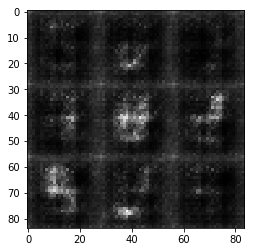

Step: 110: Epoch 1/2... Discriminator Loss: 0.7821... Generator Loss: 1.7751
Step: 120: Epoch 1/2... Discriminator Loss: 1.7910... Generator Loss: 4.7209
Step: 130: Epoch 1/2... Discriminator Loss: 1.6400... Generator Loss: 0.5137
Step: 140: Epoch 1/2... Discriminator Loss: 1.3917... Generator Loss: 0.5549
Step: 150: Epoch 1/2... Discriminator Loss: 1.6997... Generator Loss: 3.1636
Step: 160: Epoch 1/2... Discriminator Loss: 1.2549... Generator Loss: 2.7406
Step: 170: Epoch 1/2... Discriminator Loss: 1.3208... Generator Loss: 1.7905
Step: 180: Epoch 1/2... Discriminator Loss: 1.2468... Generator Loss: 1.4834
Step: 190: Epoch 1/2... Discriminator Loss: 1.0582... Generator Loss: 0.9157
Step: 200: Epoch 1/2... Discriminator Loss: 1.0793... Generator Loss: 1.0958


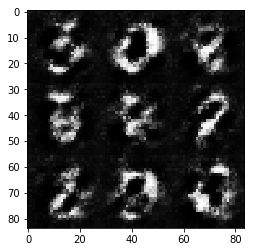

Step: 210: Epoch 1/2... Discriminator Loss: 1.0689... Generator Loss: 1.0059
Step: 220: Epoch 1/2... Discriminator Loss: 1.4575... Generator Loss: 0.4590
Step: 230: Epoch 1/2... Discriminator Loss: 1.5438... Generator Loss: 0.4303
Step: 240: Epoch 1/2... Discriminator Loss: 0.9266... Generator Loss: 1.4776
Step: 250: Epoch 1/2... Discriminator Loss: 1.0678... Generator Loss: 1.6668
Step: 260: Epoch 1/2... Discriminator Loss: 1.3973... Generator Loss: 0.5070
Step: 270: Epoch 1/2... Discriminator Loss: 1.0001... Generator Loss: 1.0942
Step: 280: Epoch 1/2... Discriminator Loss: 1.9671... Generator Loss: 3.1664
Step: 290: Epoch 1/2... Discriminator Loss: 1.6877... Generator Loss: 0.3549
Step: 300: Epoch 1/2... Discriminator Loss: 1.1282... Generator Loss: 0.6985


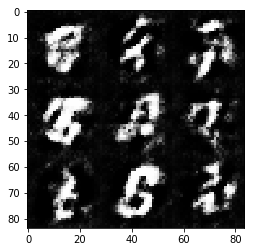

Step: 310: Epoch 1/2... Discriminator Loss: 1.2815... Generator Loss: 0.5743
Step: 320: Epoch 1/2... Discriminator Loss: 1.0805... Generator Loss: 0.7589
Step: 330: Epoch 1/2... Discriminator Loss: 1.2436... Generator Loss: 0.6353
Step: 340: Epoch 1/2... Discriminator Loss: 1.0528... Generator Loss: 1.6915
Step: 350: Epoch 1/2... Discriminator Loss: 1.2334... Generator Loss: 0.6218
Step: 360: Epoch 1/2... Discriminator Loss: 1.4998... Generator Loss: 0.4263
Step: 370: Epoch 1/2... Discriminator Loss: 0.9167... Generator Loss: 1.4170
Step: 380: Epoch 1/2... Discriminator Loss: 1.0620... Generator Loss: 0.8380
Step: 390: Epoch 1/2... Discriminator Loss: 1.1997... Generator Loss: 0.6276
Step: 400: Epoch 1/2... Discriminator Loss: 0.9700... Generator Loss: 0.9111


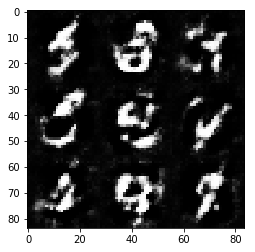

Step: 410: Epoch 1/2... Discriminator Loss: 0.8853... Generator Loss: 1.2765
Step: 420: Epoch 1/2... Discriminator Loss: 1.2542... Generator Loss: 0.5722
Step: 430: Epoch 1/2... Discriminator Loss: 0.9936... Generator Loss: 0.9416
Step: 440: Epoch 1/2... Discriminator Loss: 1.0953... Generator Loss: 1.9767
Step: 450: Epoch 1/2... Discriminator Loss: 0.7971... Generator Loss: 1.2582
Step: 460: Epoch 1/2... Discriminator Loss: 0.8383... Generator Loss: 2.1802
Step: 470: Epoch 1/2... Discriminator Loss: 0.8840... Generator Loss: 1.0833
Step: 480: Epoch 1/2... Discriminator Loss: 1.5658... Generator Loss: 0.4811
Step: 490: Epoch 1/2... Discriminator Loss: 1.0116... Generator Loss: 1.5327
Step: 500: Epoch 1/2... Discriminator Loss: 0.8208... Generator Loss: 1.3049


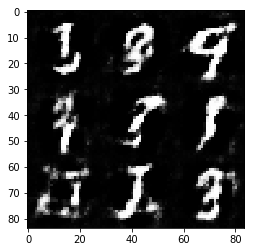

Step: 510: Epoch 1/2... Discriminator Loss: 1.0293... Generator Loss: 0.8275
Step: 520: Epoch 1/2... Discriminator Loss: 1.0819... Generator Loss: 0.8057
Step: 530: Epoch 1/2... Discriminator Loss: 0.9449... Generator Loss: 0.9564
Step: 540: Epoch 1/2... Discriminator Loss: 1.6190... Generator Loss: 0.4081
Step: 550: Epoch 1/2... Discriminator Loss: 1.2653... Generator Loss: 0.5652
Step: 560: Epoch 1/2... Discriminator Loss: 1.0004... Generator Loss: 0.9113
Step: 570: Epoch 1/2... Discriminator Loss: 1.4585... Generator Loss: 2.5476
Step: 580: Epoch 1/2... Discriminator Loss: 1.3630... Generator Loss: 0.5411
Step: 590: Epoch 1/2... Discriminator Loss: 0.9769... Generator Loss: 1.0495
Step: 600: Epoch 1/2... Discriminator Loss: 1.2298... Generator Loss: 2.4619


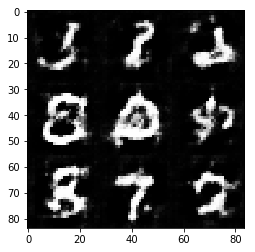

Step: 610: Epoch 1/2... Discriminator Loss: 1.1145... Generator Loss: 0.7756
Step: 620: Epoch 1/2... Discriminator Loss: 1.0233... Generator Loss: 0.9262
Step: 630: Epoch 1/2... Discriminator Loss: 0.9948... Generator Loss: 0.8632
Step: 640: Epoch 1/2... Discriminator Loss: 0.9565... Generator Loss: 1.7610
Step: 650: Epoch 1/2... Discriminator Loss: 0.9715... Generator Loss: 2.0169
Step: 660: Epoch 1/2... Discriminator Loss: 1.1196... Generator Loss: 1.5939
Step: 670: Epoch 1/2... Discriminator Loss: 0.9977... Generator Loss: 1.1205
Step: 680: Epoch 1/2... Discriminator Loss: 1.0730... Generator Loss: 2.0500
Step: 690: Epoch 1/2... Discriminator Loss: 1.0396... Generator Loss: 2.0820
Step: 700: Epoch 1/2... Discriminator Loss: 1.2359... Generator Loss: 0.6018


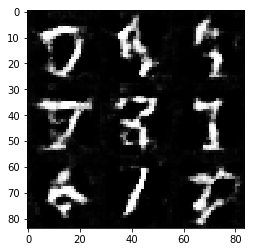

Step: 710: Epoch 1/2... Discriminator Loss: 1.0086... Generator Loss: 1.4282
Step: 720: Epoch 1/2... Discriminator Loss: 1.1188... Generator Loss: 0.7089
Step: 730: Epoch 1/2... Discriminator Loss: 0.9833... Generator Loss: 1.0546
Step: 740: Epoch 1/2... Discriminator Loss: 2.0150... Generator Loss: 0.2660
Step: 750: Epoch 1/2... Discriminator Loss: 1.0174... Generator Loss: 0.8222
Step: 760: Epoch 1/2... Discriminator Loss: 1.0770... Generator Loss: 0.7719
Step: 770: Epoch 1/2... Discriminator Loss: 1.1047... Generator Loss: 0.7852
Step: 780: Epoch 1/2... Discriminator Loss: 1.1386... Generator Loss: 2.0712
Step: 790: Epoch 1/2... Discriminator Loss: 1.1495... Generator Loss: 0.8572
Step: 800: Epoch 1/2... Discriminator Loss: 1.5748... Generator Loss: 0.4213


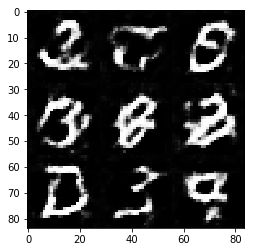

Step: 810: Epoch 1/2... Discriminator Loss: 1.5318... Generator Loss: 0.4367
Step: 820: Epoch 1/2... Discriminator Loss: 1.3593... Generator Loss: 0.5392
Step: 830: Epoch 1/2... Discriminator Loss: 0.9329... Generator Loss: 0.9523
Step: 840: Epoch 1/2... Discriminator Loss: 0.8050... Generator Loss: 1.7070
Step: 850: Epoch 1/2... Discriminator Loss: 0.9717... Generator Loss: 1.1589
Step: 860: Epoch 1/2... Discriminator Loss: 0.9825... Generator Loss: 0.8441
Step: 870: Epoch 1/2... Discriminator Loss: 0.9748... Generator Loss: 0.9279
Step: 880: Epoch 1/2... Discriminator Loss: 0.9812... Generator Loss: 0.9994
Step: 890: Epoch 1/2... Discriminator Loss: 1.0584... Generator Loss: 0.7778
Step: 900: Epoch 1/2... Discriminator Loss: 1.0304... Generator Loss: 0.9749


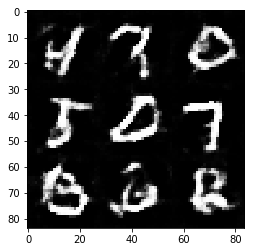

Step: 910: Epoch 1/2... Discriminator Loss: 0.8811... Generator Loss: 1.0469
Step: 920: Epoch 1/2... Discriminator Loss: 0.8774... Generator Loss: 1.2053
Step: 930: Epoch 1/2... Discriminator Loss: 0.9816... Generator Loss: 0.9378
Step: 940: Epoch 1/2... Discriminator Loss: 1.5261... Generator Loss: 0.4432
Step: 950: Epoch 1/2... Discriminator Loss: 0.9357... Generator Loss: 1.1378
Step: 960: Epoch 1/2... Discriminator Loss: 0.9417... Generator Loss: 2.1535
Step: 970: Epoch 1/2... Discriminator Loss: 1.3330... Generator Loss: 0.5642
Step: 980: Epoch 1/2... Discriminator Loss: 1.4188... Generator Loss: 0.5041
Step: 990: Epoch 1/2... Discriminator Loss: 1.0634... Generator Loss: 0.8296
Step: 1000: Epoch 1/2... Discriminator Loss: 1.2295... Generator Loss: 0.6107


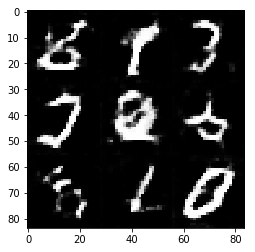

Step: 1010: Epoch 1/2... Discriminator Loss: 1.0153... Generator Loss: 1.7199
Step: 1020: Epoch 1/2... Discriminator Loss: 1.0109... Generator Loss: 1.5030
Step: 1030: Epoch 1/2... Discriminator Loss: 0.9998... Generator Loss: 1.1066
Step: 1040: Epoch 1/2... Discriminator Loss: 1.4932... Generator Loss: 0.4290
Step: 1050: Epoch 1/2... Discriminator Loss: 0.9862... Generator Loss: 1.4712
Step: 1060: Epoch 1/2... Discriminator Loss: 0.9260... Generator Loss: 1.1012
Step: 1070: Epoch 1/2... Discriminator Loss: 1.0461... Generator Loss: 0.8878
Step: 1080: Epoch 1/2... Discriminator Loss: 1.2136... Generator Loss: 2.1523
Step: 1090: Epoch 1/2... Discriminator Loss: 0.8608... Generator Loss: 1.1520
Step: 1100: Epoch 1/2... Discriminator Loss: 1.0674... Generator Loss: 0.7670


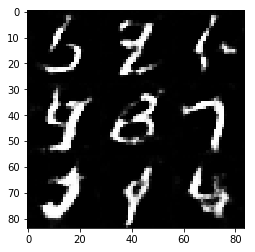

Step: 1110: Epoch 1/2... Discriminator Loss: 0.8760... Generator Loss: 1.0451
Step: 1120: Epoch 1/2... Discriminator Loss: 1.2120... Generator Loss: 0.6346
Step: 1130: Epoch 1/2... Discriminator Loss: 0.7805... Generator Loss: 1.6245
Step: 1140: Epoch 1/2... Discriminator Loss: 1.3516... Generator Loss: 0.6596
Step: 1150: Epoch 1/2... Discriminator Loss: 0.8117... Generator Loss: 1.2965
Step: 1160: Epoch 1/2... Discriminator Loss: 1.1032... Generator Loss: 0.7499
Step: 1170: Epoch 1/2... Discriminator Loss: 1.0594... Generator Loss: 0.7853
Step: 1180: Epoch 1/2... Discriminator Loss: 0.8817... Generator Loss: 1.4283
Step: 1190: Epoch 1/2... Discriminator Loss: 0.8560... Generator Loss: 1.6583
Step: 1200: Epoch 1/2... Discriminator Loss: 0.9445... Generator Loss: 0.9504


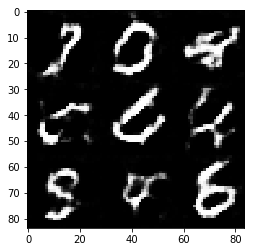

Step: 1210: Epoch 1/2... Discriminator Loss: 1.0600... Generator Loss: 2.9308
Step: 1220: Epoch 1/2... Discriminator Loss: 0.8559... Generator Loss: 1.0357
Step: 1230: Epoch 1/2... Discriminator Loss: 0.9909... Generator Loss: 0.8677
Step: 1240: Epoch 1/2... Discriminator Loss: 0.9572... Generator Loss: 0.9178
Step: 1250: Epoch 1/2... Discriminator Loss: 0.9249... Generator Loss: 1.0087
Step: 1260: Epoch 1/2... Discriminator Loss: 0.8861... Generator Loss: 0.9874
Step: 1270: Epoch 1/2... Discriminator Loss: 1.6499... Generator Loss: 0.4508
Step: 1280: Epoch 1/2... Discriminator Loss: 0.8064... Generator Loss: 1.1829
Step: 1290: Epoch 1/2... Discriminator Loss: 0.8808... Generator Loss: 1.2376
Step: 1300: Epoch 1/2... Discriminator Loss: 0.7908... Generator Loss: 1.1696


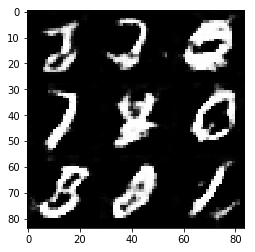

Step: 1310: Epoch 1/2... Discriminator Loss: 0.7132... Generator Loss: 1.3864
Step: 1320: Epoch 1/2... Discriminator Loss: 1.4213... Generator Loss: 0.4960
Step: 1330: Epoch 1/2... Discriminator Loss: 0.9741... Generator Loss: 0.9432
Step: 1340: Epoch 1/2... Discriminator Loss: 0.9053... Generator Loss: 1.1498
Step: 1350: Epoch 1/2... Discriminator Loss: 1.5519... Generator Loss: 2.1087
Step: 1360: Epoch 1/2... Discriminator Loss: 0.9294... Generator Loss: 0.9411
Step: 1370: Epoch 1/2... Discriminator Loss: 0.8100... Generator Loss: 1.1087
Step: 1380: Epoch 1/2... Discriminator Loss: 3.6376... Generator Loss: 0.1188
Step: 1390: Epoch 1/2... Discriminator Loss: 0.7569... Generator Loss: 1.4441
Step: 1400: Epoch 1/2... Discriminator Loss: 0.9638... Generator Loss: 0.9512


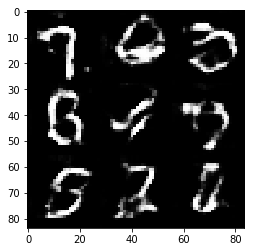

Step: 1410: Epoch 1/2... Discriminator Loss: 0.8004... Generator Loss: 1.5067
Step: 1420: Epoch 1/2... Discriminator Loss: 0.7609... Generator Loss: 1.2483
Step: 1430: Epoch 1/2... Discriminator Loss: 0.7451... Generator Loss: 1.4660
Step: 1440: Epoch 1/2... Discriminator Loss: 1.1647... Generator Loss: 0.6705
Step: 1450: Epoch 1/2... Discriminator Loss: 1.0795... Generator Loss: 0.7432
Step: 1460: Epoch 1/2... Discriminator Loss: 1.0840... Generator Loss: 0.7173
Step: 1470: Epoch 1/2... Discriminator Loss: 1.0769... Generator Loss: 1.7259
Step: 1480: Epoch 1/2... Discriminator Loss: 1.3810... Generator Loss: 0.5428
Step: 1490: Epoch 1/2... Discriminator Loss: 0.8730... Generator Loss: 1.0769
Step: 1500: Epoch 1/2... Discriminator Loss: 1.0190... Generator Loss: 0.7823


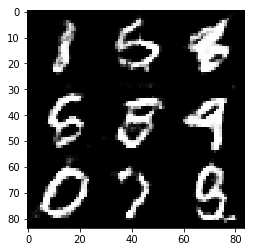

Step: 1510: Epoch 1/2... Discriminator Loss: 0.6457... Generator Loss: 1.5364
Step: 1520: Epoch 1/2... Discriminator Loss: 1.0309... Generator Loss: 0.7903
Step: 1530: Epoch 1/2... Discriminator Loss: 0.9062... Generator Loss: 0.9501
Step: 1540: Epoch 1/2... Discriminator Loss: 1.2214... Generator Loss: 0.6181
Step: 1550: Epoch 1/2... Discriminator Loss: 1.2292... Generator Loss: 0.6768
Step: 1560: Epoch 1/2... Discriminator Loss: 1.0142... Generator Loss: 0.8592
Step: 1570: Epoch 1/2... Discriminator Loss: 0.8446... Generator Loss: 1.0702
Step: 1580: Epoch 1/2... Discriminator Loss: 0.8725... Generator Loss: 1.2821
Step: 1590: Epoch 1/2... Discriminator Loss: 1.1801... Generator Loss: 0.6965
Step: 1600: Epoch 1/2... Discriminator Loss: 1.1814... Generator Loss: 0.6797


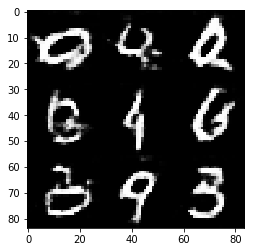

Step: 1610: Epoch 1/2... Discriminator Loss: 0.7793... Generator Loss: 1.1640
Step: 1620: Epoch 1/2... Discriminator Loss: 0.8042... Generator Loss: 1.1205
Step: 1630: Epoch 1/2... Discriminator Loss: 0.7550... Generator Loss: 2.1349
Step: 1640: Epoch 1/2... Discriminator Loss: 7.2180... Generator Loss: 8.6191
Step: 1650: Epoch 1/2... Discriminator Loss: 1.2566... Generator Loss: 0.6355
Step: 1660: Epoch 1/2... Discriminator Loss: 0.6563... Generator Loss: 1.7880
Step: 1670: Epoch 1/2... Discriminator Loss: 0.7850... Generator Loss: 1.3528
Step: 1680: Epoch 1/2... Discriminator Loss: 1.7621... Generator Loss: 0.3330
Step: 1690: Epoch 1/2... Discriminator Loss: 1.2256... Generator Loss: 0.6118
Step: 1700: Epoch 1/2... Discriminator Loss: 0.7744... Generator Loss: 1.2180


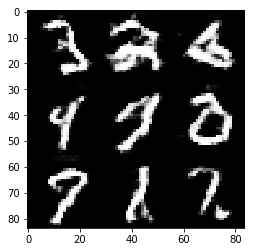

Step: 1710: Epoch 1/2... Discriminator Loss: 0.7372... Generator Loss: 1.3131
Step: 1720: Epoch 1/2... Discriminator Loss: 1.1284... Generator Loss: 0.6957
Step: 1730: Epoch 1/2... Discriminator Loss: 1.7774... Generator Loss: 4.1102
Step: 1740: Epoch 1/2... Discriminator Loss: 0.9738... Generator Loss: 0.8552
Step: 1750: Epoch 1/2... Discriminator Loss: 0.7615... Generator Loss: 1.1648
Step: 1760: Epoch 1/2... Discriminator Loss: 0.7278... Generator Loss: 1.3955
Step: 1770: Epoch 1/2... Discriminator Loss: 0.6600... Generator Loss: 1.5979
Step: 1780: Epoch 1/2... Discriminator Loss: 1.3986... Generator Loss: 0.5466
Step: 1790: Epoch 1/2... Discriminator Loss: 0.8046... Generator Loss: 1.3184
Step: 1800: Epoch 1/2... Discriminator Loss: 0.9628... Generator Loss: 1.0600


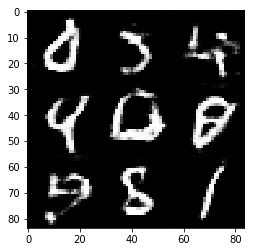

Step: 1810: Epoch 1/2... Discriminator Loss: 1.0790... Generator Loss: 0.7517
Step: 1820: Epoch 1/2... Discriminator Loss: 0.6761... Generator Loss: 1.4660
Step: 1830: Epoch 1/2... Discriminator Loss: 1.0727... Generator Loss: 0.7417
Step: 1840: Epoch 1/2... Discriminator Loss: 1.1715... Generator Loss: 1.6314
Step: 1850: Epoch 1/2... Discriminator Loss: 0.8477... Generator Loss: 1.7101
Step: 1860: Epoch 1/2... Discriminator Loss: 1.2484... Generator Loss: 0.6179
Step: 1870: Epoch 1/2... Discriminator Loss: 0.7680... Generator Loss: 1.3420
Step: 1880: Epoch 2/2... Discriminator Loss: 0.8854... Generator Loss: 0.9767
Step: 1890: Epoch 2/2... Discriminator Loss: 0.9690... Generator Loss: 0.8660
Step: 1900: Epoch 2/2... Discriminator Loss: 0.8251... Generator Loss: 1.0970


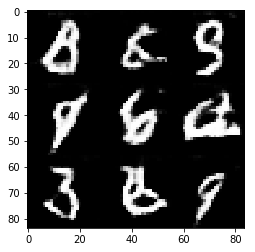

Step: 1910: Epoch 2/2... Discriminator Loss: 1.9494... Generator Loss: 2.0117
Step: 1920: Epoch 2/2... Discriminator Loss: 1.0301... Generator Loss: 2.4615
Step: 1930: Epoch 2/2... Discriminator Loss: 0.8627... Generator Loss: 1.0515
Step: 1940: Epoch 2/2... Discriminator Loss: 1.1027... Generator Loss: 0.7481
Step: 1950: Epoch 2/2... Discriminator Loss: 1.3367... Generator Loss: 0.5589
Step: 1960: Epoch 2/2... Discriminator Loss: 0.9307... Generator Loss: 0.9206
Step: 1970: Epoch 2/2... Discriminator Loss: 0.8197... Generator Loss: 1.3839
Step: 1980: Epoch 2/2... Discriminator Loss: 1.1628... Generator Loss: 2.1658
Step: 1990: Epoch 2/2... Discriminator Loss: 0.6541... Generator Loss: 1.5474
Step: 2000: Epoch 2/2... Discriminator Loss: 2.4809... Generator Loss: 0.1870


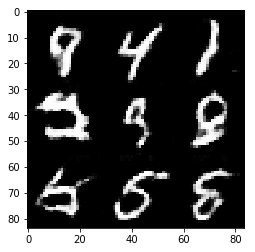

Step: 2010: Epoch 2/2... Discriminator Loss: 0.9271... Generator Loss: 0.9550
Step: 2020: Epoch 2/2... Discriminator Loss: 0.7316... Generator Loss: 1.4514
Step: 2030: Epoch 2/2... Discriminator Loss: 0.7159... Generator Loss: 1.5168
Step: 2040: Epoch 2/2... Discriminator Loss: 1.0854... Generator Loss: 0.8033
Step: 2050: Epoch 2/2... Discriminator Loss: 0.6855... Generator Loss: 1.5471
Step: 2060: Epoch 2/2... Discriminator Loss: 1.0528... Generator Loss: 0.7993
Step: 2070: Epoch 2/2... Discriminator Loss: 0.7846... Generator Loss: 1.1672
Step: 2080: Epoch 2/2... Discriminator Loss: 1.4693... Generator Loss: 0.4697
Step: 2090: Epoch 2/2... Discriminator Loss: 1.3774... Generator Loss: 0.5141
Step: 2100: Epoch 2/2... Discriminator Loss: 0.8372... Generator Loss: 1.0883


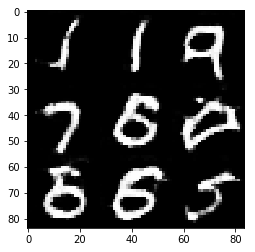

Step: 2110: Epoch 2/2... Discriminator Loss: 2.3377... Generator Loss: 0.2289
Step: 2120: Epoch 2/2... Discriminator Loss: 0.8219... Generator Loss: 1.1059
Step: 2130: Epoch 2/2... Discriminator Loss: 0.7428... Generator Loss: 1.2711
Step: 2140: Epoch 2/2... Discriminator Loss: 0.7084... Generator Loss: 1.6091
Step: 2150: Epoch 2/2... Discriminator Loss: 0.7959... Generator Loss: 2.0526
Step: 2160: Epoch 2/2... Discriminator Loss: 1.4756... Generator Loss: 4.5459
Step: 2170: Epoch 2/2... Discriminator Loss: 0.8802... Generator Loss: 1.0050
Step: 2180: Epoch 2/2... Discriminator Loss: 0.7629... Generator Loss: 1.7413
Step: 2190: Epoch 2/2... Discriminator Loss: 0.7565... Generator Loss: 2.3804
Step: 2200: Epoch 2/2... Discriminator Loss: 1.6497... Generator Loss: 0.3820


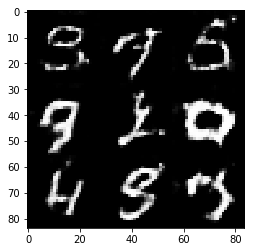

Step: 2210: Epoch 2/2... Discriminator Loss: 0.7829... Generator Loss: 1.1868
Step: 2220: Epoch 2/2... Discriminator Loss: 0.7028... Generator Loss: 1.5010
Step: 2230: Epoch 2/2... Discriminator Loss: 0.7110... Generator Loss: 2.1221
Step: 2240: Epoch 2/2... Discriminator Loss: 0.6103... Generator Loss: 1.6850
Step: 2250: Epoch 2/2... Discriminator Loss: 0.7805... Generator Loss: 1.5358
Step: 2260: Epoch 2/2... Discriminator Loss: 1.1351... Generator Loss: 0.6917
Step: 2270: Epoch 2/2... Discriminator Loss: 0.8044... Generator Loss: 1.1771
Step: 2280: Epoch 2/2... Discriminator Loss: 1.1464... Generator Loss: 0.6890
Step: 2290: Epoch 2/2... Discriminator Loss: 0.7117... Generator Loss: 1.3312
Step: 2300: Epoch 2/2... Discriminator Loss: 1.4754... Generator Loss: 3.1771


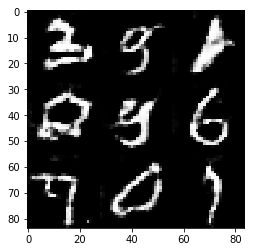

Step: 2310: Epoch 2/2... Discriminator Loss: 0.9135... Generator Loss: 0.9699
Step: 2320: Epoch 2/2... Discriminator Loss: 0.7877... Generator Loss: 1.0973
Step: 2330: Epoch 2/2... Discriminator Loss: 0.9324... Generator Loss: 1.0150
Step: 2340: Epoch 2/2... Discriminator Loss: 0.7129... Generator Loss: 1.3661
Step: 2350: Epoch 2/2... Discriminator Loss: 0.7830... Generator Loss: 1.5065
Step: 2360: Epoch 2/2... Discriminator Loss: 0.9998... Generator Loss: 0.8344
Step: 2370: Epoch 2/2... Discriminator Loss: 1.1580... Generator Loss: 0.7685
Step: 2380: Epoch 2/2... Discriminator Loss: 0.8597... Generator Loss: 1.0942
Step: 2390: Epoch 2/2... Discriminator Loss: 0.7084... Generator Loss: 1.3034
Step: 2400: Epoch 2/2... Discriminator Loss: 0.6253... Generator Loss: 2.1534


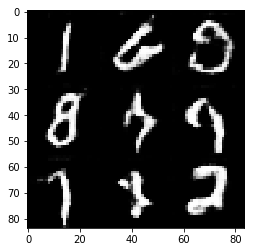

Step: 2410: Epoch 2/2... Discriminator Loss: 0.9787... Generator Loss: 0.8837
Step: 2420: Epoch 2/2... Discriminator Loss: 1.0295... Generator Loss: 0.8078
Step: 2430: Epoch 2/2... Discriminator Loss: 1.4173... Generator Loss: 3.4090
Step: 2440: Epoch 2/2... Discriminator Loss: 0.6457... Generator Loss: 1.5921
Step: 2450: Epoch 2/2... Discriminator Loss: 0.8267... Generator Loss: 1.1222
Step: 2460: Epoch 2/2... Discriminator Loss: 0.7031... Generator Loss: 1.3491
Step: 2470: Epoch 2/2... Discriminator Loss: 1.0608... Generator Loss: 0.8174
Step: 2480: Epoch 2/2... Discriminator Loss: 0.7946... Generator Loss: 1.1813
Step: 2490: Epoch 2/2... Discriminator Loss: 1.1189... Generator Loss: 0.7331
Step: 2500: Epoch 2/2... Discriminator Loss: 1.5068... Generator Loss: 0.4746


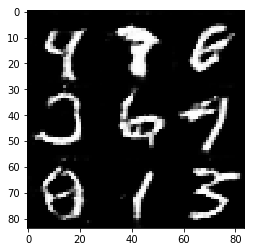

Step: 2510: Epoch 2/2... Discriminator Loss: 1.2030... Generator Loss: 0.7003
Step: 2520: Epoch 2/2... Discriminator Loss: 1.3969... Generator Loss: 3.0285
Step: 2530: Epoch 2/2... Discriminator Loss: 0.8480... Generator Loss: 1.5379
Step: 2540: Epoch 2/2... Discriminator Loss: 0.7893... Generator Loss: 1.4147
Step: 2550: Epoch 2/2... Discriminator Loss: 0.7991... Generator Loss: 1.1121
Step: 2560: Epoch 2/2... Discriminator Loss: 0.7843... Generator Loss: 1.2824
Step: 2570: Epoch 2/2... Discriminator Loss: 0.8277... Generator Loss: 1.1083
Step: 2580: Epoch 2/2... Discriminator Loss: 0.7138... Generator Loss: 1.3365
Step: 2590: Epoch 2/2... Discriminator Loss: 0.8362... Generator Loss: 2.2335
Step: 2600: Epoch 2/2... Discriminator Loss: 1.6166... Generator Loss: 0.4761


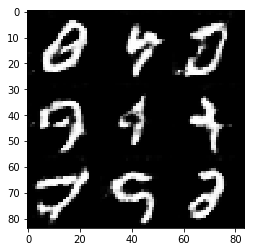

Step: 2610: Epoch 2/2... Discriminator Loss: 0.6044... Generator Loss: 1.7142
Step: 2620: Epoch 2/2... Discriminator Loss: 1.0108... Generator Loss: 0.7925
Step: 2630: Epoch 2/2... Discriminator Loss: 0.6810... Generator Loss: 1.5440
Step: 2640: Epoch 2/2... Discriminator Loss: 0.6727... Generator Loss: 1.4857
Step: 2650: Epoch 2/2... Discriminator Loss: 0.7209... Generator Loss: 2.2073
Step: 2660: Epoch 2/2... Discriminator Loss: 1.0633... Generator Loss: 0.8470
Step: 2670: Epoch 2/2... Discriminator Loss: 1.1442... Generator Loss: 0.7849
Step: 2680: Epoch 2/2... Discriminator Loss: 0.7277... Generator Loss: 1.3327
Step: 2690: Epoch 2/2... Discriminator Loss: 0.8815... Generator Loss: 0.9977
Step: 2700: Epoch 2/2... Discriminator Loss: 0.6122... Generator Loss: 1.8221


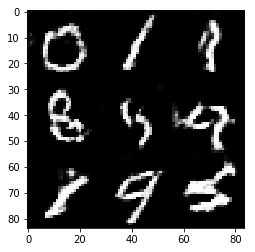

Step: 2710: Epoch 2/2... Discriminator Loss: 0.9152... Generator Loss: 0.9575
Step: 2720: Epoch 2/2... Discriminator Loss: 1.0202... Generator Loss: 0.8182
Step: 2730: Epoch 2/2... Discriminator Loss: 0.8332... Generator Loss: 1.0519
Step: 2740: Epoch 2/2... Discriminator Loss: 0.5579... Generator Loss: 1.8607
Step: 2750: Epoch 2/2... Discriminator Loss: 1.0637... Generator Loss: 0.7539
Step: 2760: Epoch 2/2... Discriminator Loss: 1.1409... Generator Loss: 0.7706
Step: 2770: Epoch 2/2... Discriminator Loss: 1.0067... Generator Loss: 0.8344
Step: 2780: Epoch 2/2... Discriminator Loss: 1.0647... Generator Loss: 0.8941
Step: 2790: Epoch 2/2... Discriminator Loss: 0.7107... Generator Loss: 1.7736
Step: 2800: Epoch 2/2... Discriminator Loss: 0.6702... Generator Loss: 1.4704


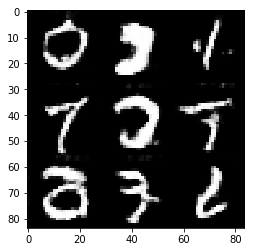

Step: 2810: Epoch 2/2... Discriminator Loss: 0.8900... Generator Loss: 0.9708
Step: 2820: Epoch 2/2... Discriminator Loss: 1.0609... Generator Loss: 0.7718
Step: 2830: Epoch 2/2... Discriminator Loss: 0.6360... Generator Loss: 1.4799
Step: 2840: Epoch 2/2... Discriminator Loss: 0.8608... Generator Loss: 1.7713
Step: 2850: Epoch 2/2... Discriminator Loss: 1.3271... Generator Loss: 0.6033
Step: 2860: Epoch 2/2... Discriminator Loss: 0.5977... Generator Loss: 2.0197
Step: 2870: Epoch 2/2... Discriminator Loss: 0.6780... Generator Loss: 2.3937
Step: 2880: Epoch 2/2... Discriminator Loss: 1.0249... Generator Loss: 2.7309
Step: 2890: Epoch 2/2... Discriminator Loss: 1.2454... Generator Loss: 0.6690
Step: 2900: Epoch 2/2... Discriminator Loss: 0.7287... Generator Loss: 1.2785


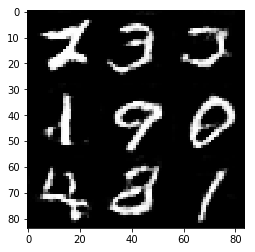

Step: 2910: Epoch 2/2... Discriminator Loss: 0.8757... Generator Loss: 1.0706
Step: 2920: Epoch 2/2... Discriminator Loss: 0.7319... Generator Loss: 1.3400
Step: 2930: Epoch 2/2... Discriminator Loss: 1.4090... Generator Loss: 0.5729
Step: 2940: Epoch 2/2... Discriminator Loss: 0.6022... Generator Loss: 1.9364
Step: 2950: Epoch 2/2... Discriminator Loss: 0.8710... Generator Loss: 1.0650
Step: 2960: Epoch 2/2... Discriminator Loss: 0.6081... Generator Loss: 1.6979
Step: 2970: Epoch 2/2... Discriminator Loss: 0.5901... Generator Loss: 1.8576
Step: 2980: Epoch 2/2... Discriminator Loss: 0.6582... Generator Loss: 1.4628
Step: 2990: Epoch 2/2... Discriminator Loss: 0.7918... Generator Loss: 1.1522
Step: 3000: Epoch 2/2... Discriminator Loss: 1.0848... Generator Loss: 0.8015


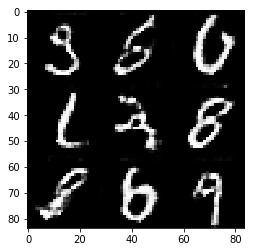

Step: 3010: Epoch 2/2... Discriminator Loss: 0.6333... Generator Loss: 1.6761
Step: 3020: Epoch 2/2... Discriminator Loss: 0.5610... Generator Loss: 1.8733
Step: 3030: Epoch 2/2... Discriminator Loss: 0.7063... Generator Loss: 1.5431
Step: 3040: Epoch 2/2... Discriminator Loss: 0.5924... Generator Loss: 1.7242
Step: 3050: Epoch 2/2... Discriminator Loss: 0.8087... Generator Loss: 1.1615
Step: 3060: Epoch 2/2... Discriminator Loss: 0.7691... Generator Loss: 1.3629
Step: 3070: Epoch 2/2... Discriminator Loss: 1.1068... Generator Loss: 0.8442
Step: 3080: Epoch 2/2... Discriminator Loss: 0.8179... Generator Loss: 1.1181
Step: 3090: Epoch 2/2... Discriminator Loss: 1.6956... Generator Loss: 0.5479
Step: 3100: Epoch 2/2... Discriminator Loss: 0.6063... Generator Loss: 1.7387


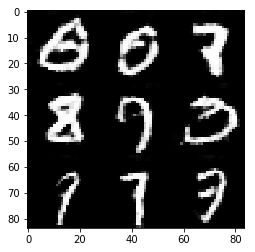

Step: 3110: Epoch 2/2... Discriminator Loss: 0.6647... Generator Loss: 1.6124
Step: 3120: Epoch 2/2... Discriminator Loss: 0.8254... Generator Loss: 1.0638
Step: 3130: Epoch 2/2... Discriminator Loss: 2.9884... Generator Loss: 5.2669
Step: 3140: Epoch 2/2... Discriminator Loss: 1.7347... Generator Loss: 0.4837
Step: 3150: Epoch 2/2... Discriminator Loss: 0.7219... Generator Loss: 2.1925
Step: 3160: Epoch 2/2... Discriminator Loss: 0.8521... Generator Loss: 1.0708
Step: 3170: Epoch 2/2... Discriminator Loss: 0.8142... Generator Loss: 1.1380
Step: 3180: Epoch 2/2... Discriminator Loss: 1.2888... Generator Loss: 0.5699
Step: 3190: Epoch 2/2... Discriminator Loss: 0.8074... Generator Loss: 2.1201
Step: 3200: Epoch 2/2... Discriminator Loss: 0.8070... Generator Loss: 1.1951


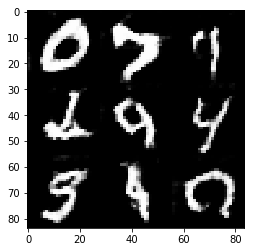

Step: 3210: Epoch 2/2... Discriminator Loss: 0.6343... Generator Loss: 1.5859
Step: 3220: Epoch 2/2... Discriminator Loss: 0.7099... Generator Loss: 1.3990
Step: 3230: Epoch 2/2... Discriminator Loss: 1.3534... Generator Loss: 3.4048
Step: 3240: Epoch 2/2... Discriminator Loss: 1.6419... Generator Loss: 0.5158
Step: 3250: Epoch 2/2... Discriminator Loss: 0.7016... Generator Loss: 1.2975
Step: 3260: Epoch 2/2... Discriminator Loss: 0.8734... Generator Loss: 0.9991
Step: 3270: Epoch 2/2... Discriminator Loss: 0.9074... Generator Loss: 1.0540
Step: 3280: Epoch 2/2... Discriminator Loss: 1.0472... Generator Loss: 0.8306
Step: 3290: Epoch 2/2... Discriminator Loss: 0.7981... Generator Loss: 1.2896
Step: 3300: Epoch 2/2... Discriminator Loss: 1.4181... Generator Loss: 0.4961


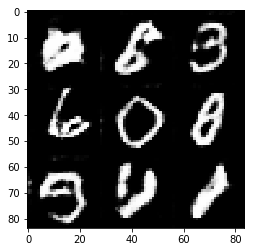

Step: 3310: Epoch 2/2... Discriminator Loss: 0.9264... Generator Loss: 0.9470
Step: 3320: Epoch 2/2... Discriminator Loss: 0.7620... Generator Loss: 1.1832
Step: 3330: Epoch 2/2... Discriminator Loss: 1.8750... Generator Loss: 0.4037
Step: 3340: Epoch 2/2... Discriminator Loss: 1.2265... Generator Loss: 2.8313
Step: 3350: Epoch 2/2... Discriminator Loss: 0.5586... Generator Loss: 1.9091
Step: 3360: Epoch 2/2... Discriminator Loss: 1.0537... Generator Loss: 0.7667
Step: 3370: Epoch 2/2... Discriminator Loss: 0.5850... Generator Loss: 1.8161
Step: 3380: Epoch 2/2... Discriminator Loss: 1.0635... Generator Loss: 0.8202
Step: 3390: Epoch 2/2... Discriminator Loss: 2.0559... Generator Loss: 0.4107
Step: 3400: Epoch 2/2... Discriminator Loss: 0.6527... Generator Loss: 1.8094


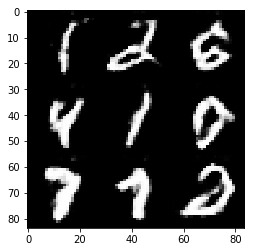

Step: 3410: Epoch 2/2... Discriminator Loss: 0.6714... Generator Loss: 1.4385
Step: 3420: Epoch 2/2... Discriminator Loss: 0.6905... Generator Loss: 1.4623
Step: 3430: Epoch 2/2... Discriminator Loss: 1.5817... Generator Loss: 0.4287
Step: 3440: Epoch 2/2... Discriminator Loss: 1.6948... Generator Loss: 0.5484
Step: 3450: Epoch 2/2... Discriminator Loss: 1.3260... Generator Loss: 0.5923
Step: 3460: Epoch 2/2... Discriminator Loss: 0.7165... Generator Loss: 1.3548
Step: 3470: Epoch 2/2... Discriminator Loss: 1.2183... Generator Loss: 0.7172
Step: 3480: Epoch 2/2... Discriminator Loss: 0.6644... Generator Loss: 1.4778
Step: 3490: Epoch 2/2... Discriminator Loss: 0.6045... Generator Loss: 1.7964
Step: 3500: Epoch 2/2... Discriminator Loss: 0.6889... Generator Loss: 1.3588


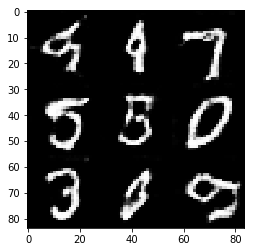

Step: 3510: Epoch 2/2... Discriminator Loss: 0.8912... Generator Loss: 1.1747
Step: 3520: Epoch 2/2... Discriminator Loss: 0.7073... Generator Loss: 1.3856
Step: 3530: Epoch 2/2... Discriminator Loss: 1.1421... Generator Loss: 0.7889
Step: 3540: Epoch 2/2... Discriminator Loss: 0.6292... Generator Loss: 2.0864
Step: 3550: Epoch 2/2... Discriminator Loss: 0.7009... Generator Loss: 1.3764
Step: 3560: Epoch 2/2... Discriminator Loss: 0.6551... Generator Loss: 1.5129
Step: 3570: Epoch 2/2... Discriminator Loss: 0.6687... Generator Loss: 1.4601
Step: 3580: Epoch 2/2... Discriminator Loss: 1.2031... Generator Loss: 0.6841
Step: 3590: Epoch 2/2... Discriminator Loss: 0.5811... Generator Loss: 1.7090
Step: 3600: Epoch 2/2... Discriminator Loss: 0.6457... Generator Loss: 1.6369


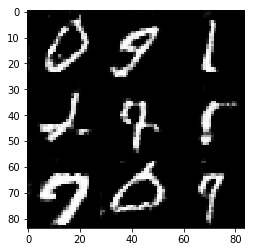

Step: 3610: Epoch 2/2... Discriminator Loss: 2.3397... Generator Loss: 0.2662
Step: 3620: Epoch 2/2... Discriminator Loss: 0.8727... Generator Loss: 2.2222
Step: 3630: Epoch 2/2... Discriminator Loss: 1.3294... Generator Loss: 0.6244
Step: 3640: Epoch 2/2... Discriminator Loss: 0.7980... Generator Loss: 1.1962
Step: 3650: Epoch 2/2... Discriminator Loss: 1.2587... Generator Loss: 0.6187
Step: 3660: Epoch 2/2... Discriminator Loss: 0.8090... Generator Loss: 1.1561
Step: 3670: Epoch 2/2... Discriminator Loss: 0.7184... Generator Loss: 1.4443
Step: 3680: Epoch 2/2... Discriminator Loss: 0.7491... Generator Loss: 1.3335
Step: 3690: Epoch 2/2... Discriminator Loss: 0.6577... Generator Loss: 1.5219
Step: 3700: Epoch 2/2... Discriminator Loss: 0.6235... Generator Loss: 1.6602


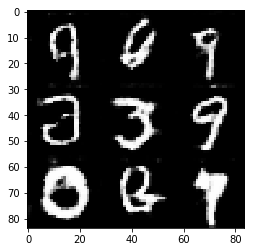

Step: 3710: Epoch 2/2... Discriminator Loss: 1.2581... Generator Loss: 4.5893
Step: 3720: Epoch 2/2... Discriminator Loss: 1.0647... Generator Loss: 0.8847
Step: 3730: Epoch 2/2... Discriminator Loss: 0.7802... Generator Loss: 1.4363
Step: 3740: Epoch 2/2... Discriminator Loss: 0.6875... Generator Loss: 1.4512
Step: 3750: Epoch 2/2... Discriminator Loss: 0.7749... Generator Loss: 1.1988
Finished with trainning


In [31]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Starting trainning
Step: 10: Epoch 1/1... Discriminator Loss: 1.7103... Generator Loss: 0.3850
Step: 20: Epoch 1/1... Discriminator Loss: 0.8467... Generator Loss: 1.3037
Step: 30: Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.6454
Step: 40: Epoch 1/1... Discriminator Loss: 0.5267... Generator Loss: 2.7197
Step: 50: Epoch 1/1... Discriminator Loss: 0.6975... Generator Loss: 1.6115
Step: 60: Epoch 1/1... Discriminator Loss: 0.4929... Generator Loss: 4.1027
Step: 70: Epoch 1/1... Discriminator Loss: 2.1396... Generator Loss: 0.2235
Step: 80: Epoch 1/1... Discriminator Loss: 1.7354... Generator Loss: 0.3763
Step: 90: Epoch 1/1... Discriminator Loss: 0.7292... Generator Loss: 1.6514
Step: 100: Epoch 1/1... Discriminator Loss: 0.7542... Generator Loss: 1.2924


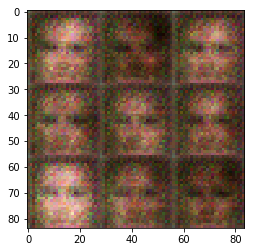

Step: 110: Epoch 1/1... Discriminator Loss: 0.7997... Generator Loss: 2.6667
Step: 120: Epoch 1/1... Discriminator Loss: 0.6527... Generator Loss: 2.6375
Step: 130: Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.6614
Step: 140: Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 0.9717
Step: 150: Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 0.9886
Step: 160: Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.5100
Step: 170: Epoch 1/1... Discriminator Loss: 0.8423... Generator Loss: 1.1047
Step: 180: Epoch 1/1... Discriminator Loss: 0.6929... Generator Loss: 1.5470
Step: 190: Epoch 1/1... Discriminator Loss: 0.7566... Generator Loss: 1.4724
Step: 200: Epoch 1/1... Discriminator Loss: 0.7790... Generator Loss: 3.0013


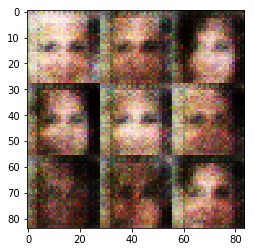

Step: 210: Epoch 1/1... Discriminator Loss: 0.7865... Generator Loss: 1.2764
Step: 220: Epoch 1/1... Discriminator Loss: 0.9400... Generator Loss: 0.9595
Step: 230: Epoch 1/1... Discriminator Loss: 0.9374... Generator Loss: 1.1206
Step: 240: Epoch 1/1... Discriminator Loss: 0.5689... Generator Loss: 2.0808
Step: 250: Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 0.8633
Step: 260: Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 2.0246
Step: 270: Epoch 1/1... Discriminator Loss: 0.7837... Generator Loss: 1.4679
Step: 280: Epoch 1/1... Discriminator Loss: 0.8832... Generator Loss: 1.0276
Step: 290: Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 2.3461
Step: 300: Epoch 1/1... Discriminator Loss: 1.7387... Generator Loss: 0.4436


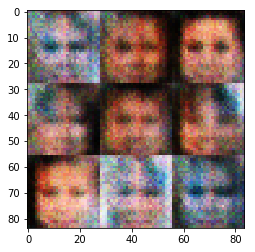

Step: 310: Epoch 1/1... Discriminator Loss: 0.8780... Generator Loss: 3.2821
Step: 320: Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 0.7958
Step: 330: Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 0.9296
Step: 340: Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 3.3816
Step: 350: Epoch 1/1... Discriminator Loss: 0.7931... Generator Loss: 1.2458
Step: 360: Epoch 1/1... Discriminator Loss: 0.6803... Generator Loss: 2.3436
Step: 370: Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 0.9335
Step: 380: Epoch 1/1... Discriminator Loss: 0.7388... Generator Loss: 1.3663
Step: 390: Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 0.9643
Step: 400: Epoch 1/1... Discriminator Loss: 0.9066... Generator Loss: 0.9899


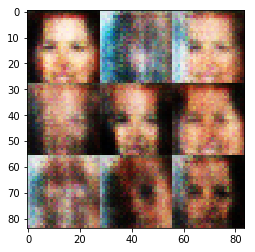

Step: 410: Epoch 1/1... Discriminator Loss: 0.7496... Generator Loss: 1.3437
Step: 420: Epoch 1/1... Discriminator Loss: 0.5105... Generator Loss: 2.3244
Step: 430: Epoch 1/1... Discriminator Loss: 0.7912... Generator Loss: 1.1574
Step: 440: Epoch 1/1... Discriminator Loss: 0.7723... Generator Loss: 2.0524
Step: 450: Epoch 1/1... Discriminator Loss: 0.8170... Generator Loss: 1.3773
Step: 460: Epoch 1/1... Discriminator Loss: 0.8002... Generator Loss: 1.6690
Step: 470: Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 0.7499
Step: 480: Epoch 1/1... Discriminator Loss: 0.6691... Generator Loss: 2.4388
Step: 490: Epoch 1/1... Discriminator Loss: 0.9257... Generator Loss: 1.3656
Step: 500: Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 1.2656


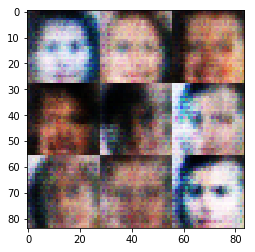

Step: 510: Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.4828
Step: 520: Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 0.7435
Step: 530: Epoch 1/1... Discriminator Loss: 0.7701... Generator Loss: 2.2480
Step: 540: Epoch 1/1... Discriminator Loss: 1.5941... Generator Loss: 0.4709
Step: 550: Epoch 1/1... Discriminator Loss: 0.8579... Generator Loss: 1.3597
Step: 560: Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.5478
Step: 570: Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.5889
Step: 580: Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 0.8416
Step: 590: Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.4668
Step: 600: Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 1.0964


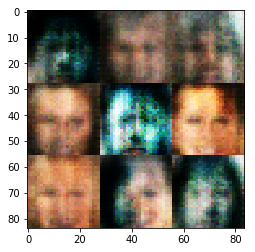

Step: 610: Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 0.9506
Step: 620: Epoch 1/1... Discriminator Loss: 1.5527... Generator Loss: 0.5342
Step: 630: Epoch 1/1... Discriminator Loss: 0.6773... Generator Loss: 2.7193
Step: 640: Epoch 1/1... Discriminator Loss: 0.7342... Generator Loss: 1.3855
Step: 650: Epoch 1/1... Discriminator Loss: 0.7454... Generator Loss: 1.3641
Step: 660: Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 1.0200
Step: 670: Epoch 1/1... Discriminator Loss: 0.6524... Generator Loss: 1.7400
Step: 680: Epoch 1/1... Discriminator Loss: 0.6744... Generator Loss: 1.9360
Step: 690: Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 1.0359
Step: 700: Epoch 1/1... Discriminator Loss: 0.4834... Generator Loss: 2.8109


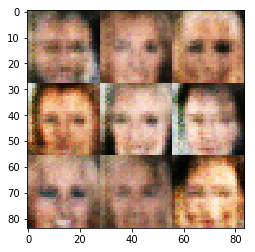

Step: 710: Epoch 1/1... Discriminator Loss: 0.9225... Generator Loss: 1.0107
Step: 720: Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 0.6993
Step: 730: Epoch 1/1... Discriminator Loss: 0.6406... Generator Loss: 1.7038
Step: 740: Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 3.6162
Step: 750: Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 0.9976
Step: 760: Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 0.6240
Step: 770: Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.5997
Step: 780: Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.4572
Step: 790: Epoch 1/1... Discriminator Loss: 0.8877... Generator Loss: 2.0262
Step: 800: Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.5936


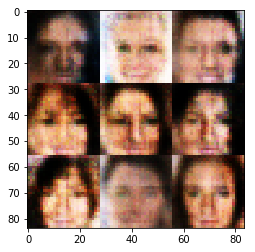

Step: 810: Epoch 1/1... Discriminator Loss: 0.8013... Generator Loss: 1.2992
Step: 820: Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.6887
Step: 830: Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.6878
Step: 840: Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.6684
Step: 850: Epoch 1/1... Discriminator Loss: 1.7216... Generator Loss: 0.3315
Step: 860: Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 2.3417
Step: 870: Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.5829
Step: 880: Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 2.3031
Step: 890: Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 0.7940
Step: 900: Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 2.8541


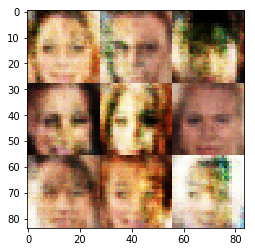

Step: 910: Epoch 1/1... Discriminator Loss: 0.7581... Generator Loss: 1.8352
Step: 920: Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 1.4497
Step: 930: Epoch 1/1... Discriminator Loss: 2.3342... Generator Loss: 0.1891
Step: 940: Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 0.8948
Step: 950: Epoch 1/1... Discriminator Loss: 0.8645... Generator Loss: 2.3679
Step: 960: Epoch 1/1... Discriminator Loss: 0.9986... Generator Loss: 1.2679
Step: 970: Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.7015
Step: 980: Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 1.5450
Step: 990: Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 0.7977
Step: 1000: Epoch 1/1... Discriminator Loss: 0.8462... Generator Loss: 1.1367


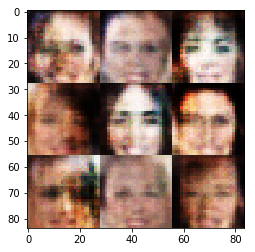

Step: 1010: Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 1.6779
Step: 1020: Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 1.8806
Step: 1030: Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.7468
Step: 1040: Epoch 1/1... Discriminator Loss: 1.6791... Generator Loss: 0.4097
Step: 1050: Epoch 1/1... Discriminator Loss: 1.0496... Generator Loss: 0.7660
Step: 1060: Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 1.2925
Step: 1070: Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 0.9742
Step: 1080: Epoch 1/1... Discriminator Loss: 0.9239... Generator Loss: 1.1347
Step: 1090: Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.6782
Step: 1100: Epoch 1/1... Discriminator Loss: 0.8199... Generator Loss: 1.3036


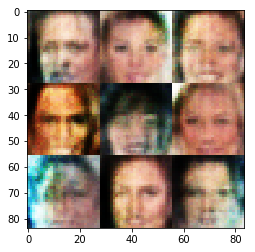

Step: 1110: Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 0.7054
Step: 1120: Epoch 1/1... Discriminator Loss: 0.9400... Generator Loss: 0.9339
Step: 1130: Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 0.8728
Step: 1140: Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.5864
Step: 1150: Epoch 1/1... Discriminator Loss: 0.6188... Generator Loss: 2.4827
Step: 1160: Epoch 1/1... Discriminator Loss: 0.6882... Generator Loss: 1.7896
Step: 1170: Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.6122
Step: 1180: Epoch 1/1... Discriminator Loss: 0.6628... Generator Loss: 1.4047
Step: 1190: Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.5380
Step: 1200: Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.5375


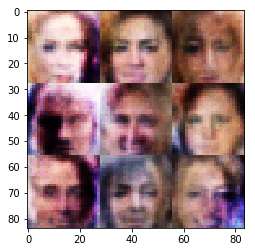

Step: 1210: Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 0.8304
Step: 1220: Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.7158
Step: 1230: Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 0.6610
Step: 1240: Epoch 1/1... Discriminator Loss: 0.7807... Generator Loss: 1.2714
Step: 1250: Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 0.7511
Step: 1260: Epoch 1/1... Discriminator Loss: 1.9423... Generator Loss: 0.2812
Step: 1270: Epoch 1/1... Discriminator Loss: 0.9255... Generator Loss: 2.1804
Step: 1280: Epoch 1/1... Discriminator Loss: 0.5819... Generator Loss: 2.6841
Step: 1290: Epoch 1/1... Discriminator Loss: 0.6671... Generator Loss: 2.4487
Step: 1300: Epoch 1/1... Discriminator Loss: 0.6238... Generator Loss: 1.8255


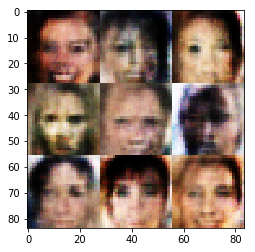

Step: 1310: Epoch 1/1... Discriminator Loss: 0.6543... Generator Loss: 1.4556
Step: 1320: Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 3.4525
Step: 1330: Epoch 1/1... Discriminator Loss: 0.8754... Generator Loss: 2.2615
Step: 1340: Epoch 1/1... Discriminator Loss: 0.6049... Generator Loss: 2.0303
Step: 1350: Epoch 1/1... Discriminator Loss: 0.6447... Generator Loss: 1.9405
Step: 1360: Epoch 1/1... Discriminator Loss: 0.4814... Generator Loss: 2.9643
Step: 1370: Epoch 1/1... Discriminator Loss: 0.6584... Generator Loss: 1.4921
Step: 1380: Epoch 1/1... Discriminator Loss: 0.7578... Generator Loss: 1.2416
Step: 1390: Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 4.2629
Step: 1400: Epoch 1/1... Discriminator Loss: 0.5827... Generator Loss: 2.7813


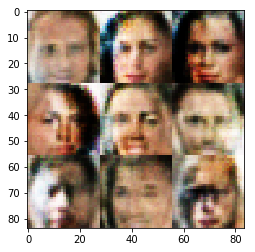

Step: 1410: Epoch 1/1... Discriminator Loss: 0.7351... Generator Loss: 1.2199
Step: 1420: Epoch 1/1... Discriminator Loss: 1.8979... Generator Loss: 0.2836
Step: 1430: Epoch 1/1... Discriminator Loss: 0.5814... Generator Loss: 1.8531
Step: 1440: Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 0.6483
Step: 1450: Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 0.8082
Step: 1460: Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 0.7357
Step: 1470: Epoch 1/1... Discriminator Loss: 1.5841... Generator Loss: 0.3846
Step: 1480: Epoch 1/1... Discriminator Loss: 0.5918... Generator Loss: 1.8256
Step: 1490: Epoch 1/1... Discriminator Loss: 0.5898... Generator Loss: 3.2127
Step: 1500: Epoch 1/1... Discriminator Loss: 0.5802... Generator Loss: 3.2385


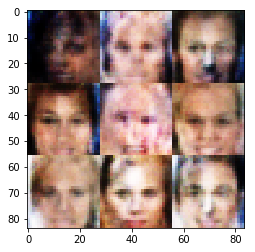

Step: 1510: Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 5.7400
Step: 1520: Epoch 1/1... Discriminator Loss: 0.7174... Generator Loss: 1.2535
Step: 1530: Epoch 1/1... Discriminator Loss: 1.0834... Generator Loss: 0.7305
Step: 1540: Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 0.7262
Step: 1550: Epoch 1/1... Discriminator Loss: 0.7400... Generator Loss: 1.2280
Step: 1560: Epoch 1/1... Discriminator Loss: 0.4379... Generator Loss: 3.6275
Step: 1570: Epoch 1/1... Discriminator Loss: 0.9866... Generator Loss: 3.5976
Step: 1580: Epoch 1/1... Discriminator Loss: 0.7362... Generator Loss: 3.6311
Step: 1590: Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 5.9191
Step: 1600: Epoch 1/1... Discriminator Loss: 0.5875... Generator Loss: 1.7188


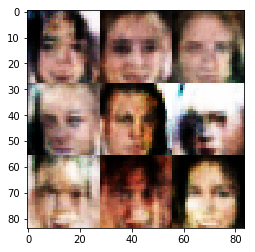

Step: 1610: Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.6736
Step: 1620: Epoch 1/1... Discriminator Loss: 0.8550... Generator Loss: 1.0227
Step: 1630: Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 0.9770
Step: 1640: Epoch 1/1... Discriminator Loss: 0.4175... Generator Loss: 4.5999
Step: 1650: Epoch 1/1... Discriminator Loss: 0.4776... Generator Loss: 2.9322
Step: 1660: Epoch 1/1... Discriminator Loss: 0.7990... Generator Loss: 1.1461
Step: 1670: Epoch 1/1... Discriminator Loss: 0.8031... Generator Loss: 1.2140
Step: 1680: Epoch 1/1... Discriminator Loss: 0.4718... Generator Loss: 2.5740
Step: 1690: Epoch 1/1... Discriminator Loss: 0.4538... Generator Loss: 3.6772
Step: 1700: Epoch 1/1... Discriminator Loss: 0.5511... Generator Loss: 1.7857


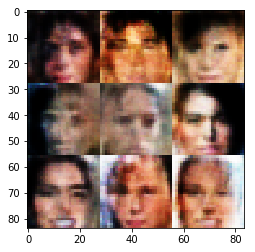

Step: 1710: Epoch 1/1... Discriminator Loss: 0.6223... Generator Loss: 1.4871
Step: 1720: Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 0.8237
Step: 1730: Epoch 1/1... Discriminator Loss: 0.7910... Generator Loss: 4.8538
Step: 1740: Epoch 1/1... Discriminator Loss: 2.0716... Generator Loss: 0.2811
Step: 1750: Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 0.7241
Step: 1760: Epoch 1/1... Discriminator Loss: 0.5053... Generator Loss: 2.2480
Step: 1770: Epoch 1/1... Discriminator Loss: 1.0007... Generator Loss: 0.8372
Step: 1780: Epoch 1/1... Discriminator Loss: 0.3940... Generator Loss: 3.5574
Step: 1790: Epoch 1/1... Discriminator Loss: 0.7539... Generator Loss: 1.1866
Step: 1800: Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.5387


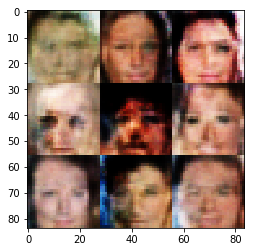

Step: 1810: Epoch 1/1... Discriminator Loss: 0.3863... Generator Loss: 3.3121
Step: 1820: Epoch 1/1... Discriminator Loss: 0.5702... Generator Loss: 1.7182
Step: 1830: Epoch 1/1... Discriminator Loss: 0.5722... Generator Loss: 1.7698
Step: 1840: Epoch 1/1... Discriminator Loss: 0.9208... Generator Loss: 0.8767
Step: 1850: Epoch 1/1... Discriminator Loss: 0.5879... Generator Loss: 1.6615
Step: 1860: Epoch 1/1... Discriminator Loss: 0.5662... Generator Loss: 1.8469
Step: 1870: Epoch 1/1... Discriminator Loss: 0.4924... Generator Loss: 2.9480
Step: 1880: Epoch 1/1... Discriminator Loss: 0.4224... Generator Loss: 3.4162
Step: 1890: Epoch 1/1... Discriminator Loss: 0.4175... Generator Loss: 3.6223
Step: 1900: Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 2.8740


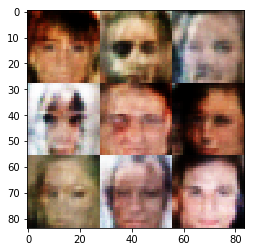

Step: 1910: Epoch 1/1... Discriminator Loss: 1.6099... Generator Loss: 0.4509
Step: 1920: Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 0.7716
Step: 1930: Epoch 1/1... Discriminator Loss: 0.7779... Generator Loss: 1.1766
Step: 1940: Epoch 1/1... Discriminator Loss: 0.3864... Generator Loss: 3.7644
Step: 1950: Epoch 1/1... Discriminator Loss: 0.6003... Generator Loss: 4.1681
Step: 1960: Epoch 1/1... Discriminator Loss: 0.3713... Generator Loss: 4.7259
Step: 1970: Epoch 1/1... Discriminator Loss: 0.3627... Generator Loss: 4.2178
Step: 1980: Epoch 1/1... Discriminator Loss: 0.8745... Generator Loss: 3.9573
Step: 1990: Epoch 1/1... Discriminator Loss: 0.5511... Generator Loss: 1.8555
Step: 2000: Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 1.0955


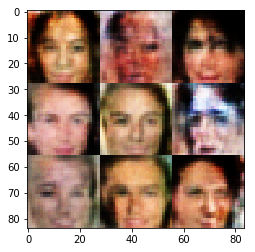

Step: 2010: Epoch 1/1... Discriminator Loss: 0.5140... Generator Loss: 2.2869
Step: 2020: Epoch 1/1... Discriminator Loss: 0.4197... Generator Loss: 2.6973
Step: 2030: Epoch 1/1... Discriminator Loss: 0.6520... Generator Loss: 1.9648
Step: 2040: Epoch 1/1... Discriminator Loss: 0.7986... Generator Loss: 4.9685
Step: 2050: Epoch 1/1... Discriminator Loss: 0.4733... Generator Loss: 4.9243
Step: 2060: Epoch 1/1... Discriminator Loss: 0.4069... Generator Loss: 2.9303
Step: 2070: Epoch 1/1... Discriminator Loss: 0.3718... Generator Loss: 3.8062
Step: 2080: Epoch 1/1... Discriminator Loss: 0.4311... Generator Loss: 4.0798
Step: 2090: Epoch 1/1... Discriminator Loss: 0.6121... Generator Loss: 1.5404
Step: 2100: Epoch 1/1... Discriminator Loss: 0.5120... Generator Loss: 2.1303


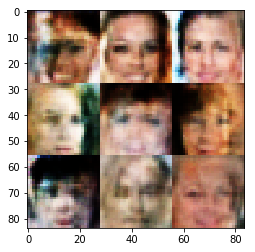

Step: 2110: Epoch 1/1... Discriminator Loss: 0.3887... Generator Loss: 3.1929
Step: 2120: Epoch 1/1... Discriminator Loss: 0.4296... Generator Loss: 4.3534
Step: 2130: Epoch 1/1... Discriminator Loss: 4.2614... Generator Loss: 4.7410
Step: 2140: Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.8332
Step: 2150: Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.5553
Step: 2160: Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 2.6486
Step: 2170: Epoch 1/1... Discriminator Loss: 0.5075... Generator Loss: 2.1010
Step: 2180: Epoch 1/1... Discriminator Loss: 1.7880... Generator Loss: 0.3173
Step: 2190: Epoch 1/1... Discriminator Loss: 0.6603... Generator Loss: 1.9051
Step: 2200: Epoch 1/1... Discriminator Loss: 0.4449... Generator Loss: 2.7229


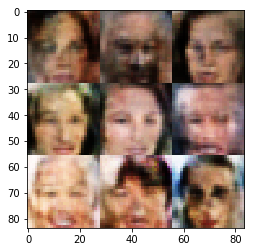

Step: 2210: Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.4425
Step: 2220: Epoch 1/1... Discriminator Loss: 0.8056... Generator Loss: 1.1713
Step: 2230: Epoch 1/1... Discriminator Loss: 0.5607... Generator Loss: 1.9381
Step: 2240: Epoch 1/1... Discriminator Loss: 0.4567... Generator Loss: 2.5189
Step: 2250: Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 0.7785
Step: 2260: Epoch 1/1... Discriminator Loss: 0.4254... Generator Loss: 2.7294
Step: 2270: Epoch 1/1... Discriminator Loss: 0.4404... Generator Loss: 2.6358
Step: 2280: Epoch 1/1... Discriminator Loss: 0.4391... Generator Loss: 2.5486
Step: 2290: Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 2.8936
Step: 2300: Epoch 1/1... Discriminator Loss: 0.4853... Generator Loss: 3.3772


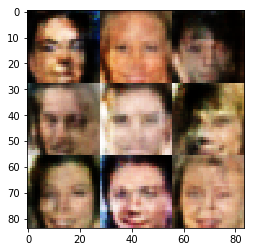

Step: 2310: Epoch 1/1... Discriminator Loss: 1.9449... Generator Loss: 0.3004
Step: 2320: Epoch 1/1... Discriminator Loss: 0.5180... Generator Loss: 3.4628
Step: 2330: Epoch 1/1... Discriminator Loss: 0.5282... Generator Loss: 1.8846
Step: 2340: Epoch 1/1... Discriminator Loss: 0.5217... Generator Loss: 2.2326
Step: 2350: Epoch 1/1... Discriminator Loss: 0.4359... Generator Loss: 2.5264
Step: 2360: Epoch 1/1... Discriminator Loss: 0.4632... Generator Loss: 2.3526
Step: 2370: Epoch 1/1... Discriminator Loss: 0.3739... Generator Loss: 3.8144
Step: 2380: Epoch 1/1... Discriminator Loss: 0.4897... Generator Loss: 3.0945
Step: 2390: Epoch 1/1... Discriminator Loss: 0.4513... Generator Loss: 2.3673
Step: 2400: Epoch 1/1... Discriminator Loss: 0.3615... Generator Loss: 4.3293


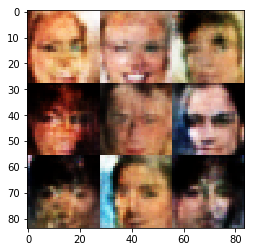

Step: 2410: Epoch 1/1... Discriminator Loss: 0.4184... Generator Loss: 3.6788
Step: 2420: Epoch 1/1... Discriminator Loss: 1.8476... Generator Loss: 4.7782
Step: 2430: Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 1.0090
Step: 2440: Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 1.1886
Step: 2450: Epoch 1/1... Discriminator Loss: 0.5042... Generator Loss: 2.0989
Step: 2460: Epoch 1/1... Discriminator Loss: 0.6316... Generator Loss: 3.2279
Step: 2470: Epoch 1/1... Discriminator Loss: 0.8198... Generator Loss: 3.6272
Step: 2480: Epoch 1/1... Discriminator Loss: 0.6135... Generator Loss: 1.8042
Step: 2490: Epoch 1/1... Discriminator Loss: 0.6418... Generator Loss: 1.5826
Step: 2500: Epoch 1/1... Discriminator Loss: 0.4397... Generator Loss: 2.8403


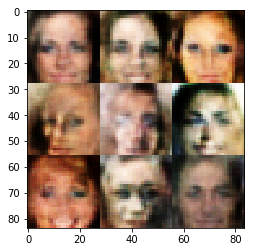

Step: 2510: Epoch 1/1... Discriminator Loss: 0.4419... Generator Loss: 4.5261
Step: 2520: Epoch 1/1... Discriminator Loss: 0.3764... Generator Loss: 3.5491
Step: 2530: Epoch 1/1... Discriminator Loss: 0.4034... Generator Loss: 3.3695
Step: 2540: Epoch 1/1... Discriminator Loss: 0.4219... Generator Loss: 2.8672
Step: 2550: Epoch 1/1... Discriminator Loss: 0.6877... Generator Loss: 1.3816
Step: 2560: Epoch 1/1... Discriminator Loss: 0.4025... Generator Loss: 2.9485
Step: 2570: Epoch 1/1... Discriminator Loss: 0.4459... Generator Loss: 2.5399
Step: 2580: Epoch 1/1... Discriminator Loss: 0.3783... Generator Loss: 3.8194
Step: 2590: Epoch 1/1... Discriminator Loss: 0.3719... Generator Loss: 3.4907
Step: 2600: Epoch 1/1... Discriminator Loss: 0.4677... Generator Loss: 3.3998


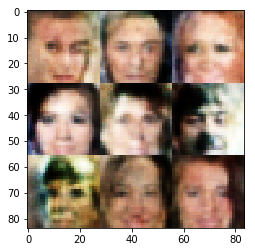

Step: 2610: Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 2.2349
Step: 2620: Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 1.6572
Step: 2630: Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 1.2185
Step: 2640: Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 0.7853
Step: 2650: Epoch 1/1... Discriminator Loss: 0.6966... Generator Loss: 2.2004
Step: 2660: Epoch 1/1... Discriminator Loss: 0.6316... Generator Loss: 1.5263
Step: 2670: Epoch 1/1... Discriminator Loss: 0.3932... Generator Loss: 3.4775
Step: 2680: Epoch 1/1... Discriminator Loss: 0.5171... Generator Loss: 2.4143
Step: 2690: Epoch 1/1... Discriminator Loss: 0.4093... Generator Loss: 2.8703
Step: 2700: Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 4.2389


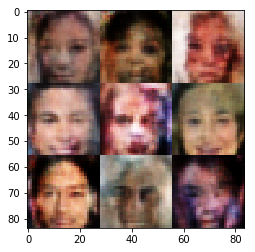

Step: 2710: Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 0.7812
Step: 2720: Epoch 1/1... Discriminator Loss: 0.4229... Generator Loss: 2.9472
Step: 2730: Epoch 1/1... Discriminator Loss: 0.4613... Generator Loss: 2.6615
Step: 2740: Epoch 1/1... Discriminator Loss: 0.4034... Generator Loss: 3.3447
Step: 2750: Epoch 1/1... Discriminator Loss: 0.5111... Generator Loss: 2.1610
Step: 2760: Epoch 1/1... Discriminator Loss: 0.5076... Generator Loss: 3.5294
Step: 2770: Epoch 1/1... Discriminator Loss: 0.4291... Generator Loss: 2.7043
Step: 2780: Epoch 1/1... Discriminator Loss: 0.3577... Generator Loss: 4.4556
Step: 2790: Epoch 1/1... Discriminator Loss: 0.5527... Generator Loss: 1.9110
Step: 2800: Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.6023


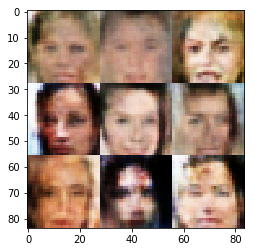

Step: 2810: Epoch 1/1... Discriminator Loss: 0.7030... Generator Loss: 1.4578
Step: 2820: Epoch 1/1... Discriminator Loss: 0.6033... Generator Loss: 1.6848
Step: 2830: Epoch 1/1... Discriminator Loss: 0.5545... Generator Loss: 1.8883
Step: 2840: Epoch 1/1... Discriminator Loss: 0.4577... Generator Loss: 2.3820
Step: 2850: Epoch 1/1... Discriminator Loss: 0.6040... Generator Loss: 1.6172
Step: 2860: Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 3.0848
Step: 2870: Epoch 1/1... Discriminator Loss: 0.5551... Generator Loss: 3.0057
Step: 2880: Epoch 1/1... Discriminator Loss: 0.3734... Generator Loss: 3.4210
Step: 2890: Epoch 1/1... Discriminator Loss: 1.0633... Generator Loss: 0.7888
Step: 2900: Epoch 1/1... Discriminator Loss: 0.5958... Generator Loss: 1.6827


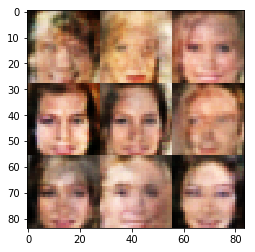

Step: 2910: Epoch 1/1... Discriminator Loss: 0.4292... Generator Loss: 2.6791
Step: 2920: Epoch 1/1... Discriminator Loss: 2.3172... Generator Loss: 0.2123
Step: 2930: Epoch 1/1... Discriminator Loss: 0.7702... Generator Loss: 3.4874
Step: 2940: Epoch 1/1... Discriminator Loss: 0.6887... Generator Loss: 1.3256
Step: 2950: Epoch 1/1... Discriminator Loss: 0.4609... Generator Loss: 2.4769
Step: 2960: Epoch 1/1... Discriminator Loss: 0.5461... Generator Loss: 1.8458
Step: 2970: Epoch 1/1... Discriminator Loss: 0.6688... Generator Loss: 1.4220
Step: 2980: Epoch 1/1... Discriminator Loss: 0.3989... Generator Loss: 4.2546
Step: 2990: Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.5915
Step: 3000: Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.6792


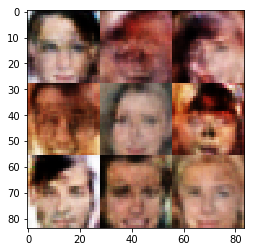

Step: 3010: Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 3.6463
Step: 3020: Epoch 1/1... Discriminator Loss: 0.5281... Generator Loss: 2.0311
Step: 3030: Epoch 1/1... Discriminator Loss: 0.8124... Generator Loss: 1.1617
Step: 3040: Epoch 1/1... Discriminator Loss: 0.6035... Generator Loss: 3.4483
Step: 3050: Epoch 1/1... Discriminator Loss: 0.5631... Generator Loss: 3.1521
Step: 3060: Epoch 1/1... Discriminator Loss: 0.5186... Generator Loss: 2.2167
Step: 3070: Epoch 1/1... Discriminator Loss: 0.4704... Generator Loss: 2.4350
Step: 3080: Epoch 1/1... Discriminator Loss: 0.6378... Generator Loss: 1.4934
Step: 3090: Epoch 1/1... Discriminator Loss: 0.4489... Generator Loss: 3.5604
Step: 3100: Epoch 1/1... Discriminator Loss: 0.5629... Generator Loss: 1.7722


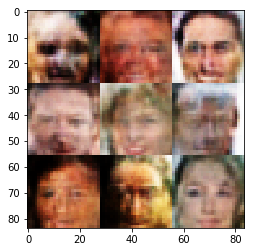

Step: 3110: Epoch 1/1... Discriminator Loss: 0.3814... Generator Loss: 3.3488
Step: 3120: Epoch 1/1... Discriminator Loss: 0.5060... Generator Loss: 2.2637
Step: 3130: Epoch 1/1... Discriminator Loss: 0.3756... Generator Loss: 3.8444
Step: 3140: Epoch 1/1... Discriminator Loss: 0.4105... Generator Loss: 2.8245
Step: 3150: Epoch 1/1... Discriminator Loss: 0.4286... Generator Loss: 2.7891
Step: 3160: Epoch 1/1... Discriminator Loss: 0.4332... Generator Loss: 3.1120
Step: 3170: Epoch 1/1... Discriminator Loss: 0.4411... Generator Loss: 2.5553
Step: 3180: Epoch 1/1... Discriminator Loss: 0.6058... Generator Loss: 1.5886
Step: 3190: Epoch 1/1... Discriminator Loss: 0.3986... Generator Loss: 3.2632
Step: 3200: Epoch 1/1... Discriminator Loss: 0.3970... Generator Loss: 3.0721


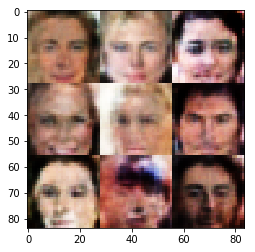

Step: 3210: Epoch 1/1... Discriminator Loss: 0.4837... Generator Loss: 2.2956
Step: 3220: Epoch 1/1... Discriminator Loss: 0.4061... Generator Loss: 3.4309
Step: 3230: Epoch 1/1... Discriminator Loss: 1.7290... Generator Loss: 3.4930
Step: 3240: Epoch 1/1... Discriminator Loss: 0.7156... Generator Loss: 1.6033
Step: 3250: Epoch 1/1... Discriminator Loss: 0.4727... Generator Loss: 2.7675
Step: 3260: Epoch 1/1... Discriminator Loss: 0.4151... Generator Loss: 2.8496
Step: 3270: Epoch 1/1... Discriminator Loss: 0.3835... Generator Loss: 3.3519
Step: 3280: Epoch 1/1... Discriminator Loss: 0.5177... Generator Loss: 2.0780
Step: 3290: Epoch 1/1... Discriminator Loss: 0.4782... Generator Loss: 2.6191
Step: 3300: Epoch 1/1... Discriminator Loss: 0.6489... Generator Loss: 3.7577


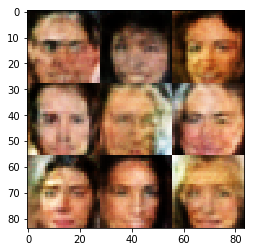

Step: 3310: Epoch 1/1... Discriminator Loss: 2.0866... Generator Loss: 0.2584
Step: 3320: Epoch 1/1... Discriminator Loss: 0.6681... Generator Loss: 1.3908
Step: 3330: Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 3.3167
Step: 3340: Epoch 1/1... Discriminator Loss: 0.5575... Generator Loss: 2.1076
Step: 3350: Epoch 1/1... Discriminator Loss: 0.5528... Generator Loss: 1.9792
Step: 3360: Epoch 1/1... Discriminator Loss: 0.3659... Generator Loss: 4.4393
Step: 3370: Epoch 1/1... Discriminator Loss: 0.3584... Generator Loss: 4.5284
Step: 3380: Epoch 1/1... Discriminator Loss: 0.4560... Generator Loss: 3.2299
Step: 3390: Epoch 1/1... Discriminator Loss: 0.4572... Generator Loss: 3.1175
Step: 3400: Epoch 1/1... Discriminator Loss: 0.4249... Generator Loss: 2.9253


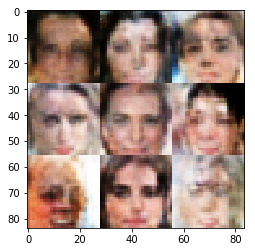

Step: 3410: Epoch 1/1... Discriminator Loss: 0.7299... Generator Loss: 1.3431
Step: 3420: Epoch 1/1... Discriminator Loss: 0.5765... Generator Loss: 3.9234
Step: 3430: Epoch 1/1... Discriminator Loss: 0.5503... Generator Loss: 2.3926
Step: 3440: Epoch 1/1... Discriminator Loss: 4.0920... Generator Loss: 5.3438
Step: 3450: Epoch 1/1... Discriminator Loss: 0.5890... Generator Loss: 3.2232
Step: 3460: Epoch 1/1... Discriminator Loss: 0.5970... Generator Loss: 1.8486
Step: 3470: Epoch 1/1... Discriminator Loss: 0.5528... Generator Loss: 2.5896
Step: 3480: Epoch 1/1... Discriminator Loss: 0.4543... Generator Loss: 3.0155
Step: 3490: Epoch 1/1... Discriminator Loss: 0.9898... Generator Loss: 0.8490
Step: 3500: Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 0.9167


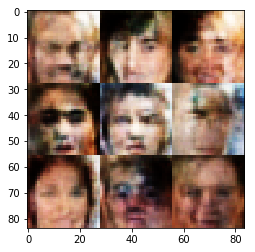

Step: 3510: Epoch 1/1... Discriminator Loss: 0.3622... Generator Loss: 4.7320
Step: 3520: Epoch 1/1... Discriminator Loss: 0.3885... Generator Loss: 3.4882
Step: 3530: Epoch 1/1... Discriminator Loss: 0.4445... Generator Loss: 2.5415
Step: 3540: Epoch 1/1... Discriminator Loss: 0.5193... Generator Loss: 1.9665
Step: 3550: Epoch 1/1... Discriminator Loss: 0.4573... Generator Loss: 2.4620
Step: 3560: Epoch 1/1... Discriminator Loss: 0.4571... Generator Loss: 2.4673
Step: 3570: Epoch 1/1... Discriminator Loss: 0.5492... Generator Loss: 1.8009
Step: 3580: Epoch 1/1... Discriminator Loss: 0.4550... Generator Loss: 2.4140
Step: 3590: Epoch 1/1... Discriminator Loss: 0.5991... Generator Loss: 1.7821
Step: 3600: Epoch 1/1... Discriminator Loss: 0.4436... Generator Loss: 2.4915


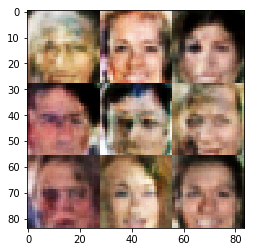

Step: 3610: Epoch 1/1... Discriminator Loss: 0.5443... Generator Loss: 1.8389
Step: 3620: Epoch 1/1... Discriminator Loss: 0.4153... Generator Loss: 3.0166
Step: 3630: Epoch 1/1... Discriminator Loss: 0.3614... Generator Loss: 4.2709
Step: 3640: Epoch 1/1... Discriminator Loss: 0.4042... Generator Loss: 3.5900
Step: 3650: Epoch 1/1... Discriminator Loss: 0.3759... Generator Loss: 3.6472
Step: 3660: Epoch 1/1... Discriminator Loss: 0.4420... Generator Loss: 2.6665
Step: 3670: Epoch 1/1... Discriminator Loss: 0.3988... Generator Loss: 5.6242
Step: 3680: Epoch 1/1... Discriminator Loss: 1.8046... Generator Loss: 4.2014
Step: 3690: Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 3.9820
Step: 3700: Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 0.8216


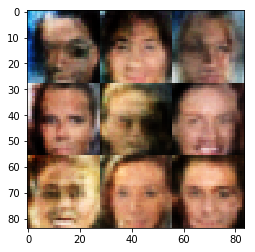

Step: 3710: Epoch 1/1... Discriminator Loss: 0.7134... Generator Loss: 1.2982
Step: 3720: Epoch 1/1... Discriminator Loss: 0.4498... Generator Loss: 2.5460
Step: 3730: Epoch 1/1... Discriminator Loss: 0.7360... Generator Loss: 1.3612
Step: 3740: Epoch 1/1... Discriminator Loss: 0.4212... Generator Loss: 3.7673
Step: 3750: Epoch 1/1... Discriminator Loss: 0.5118... Generator Loss: 2.0153
Step: 3760: Epoch 1/1... Discriminator Loss: 0.5984... Generator Loss: 1.5968
Step: 3770: Epoch 1/1... Discriminator Loss: 0.5076... Generator Loss: 2.1565
Step: 3780: Epoch 1/1... Discriminator Loss: 0.6879... Generator Loss: 1.4131
Step: 3790: Epoch 1/1... Discriminator Loss: 0.3916... Generator Loss: 3.1927
Step: 3800: Epoch 1/1... Discriminator Loss: 0.4166... Generator Loss: 2.9614


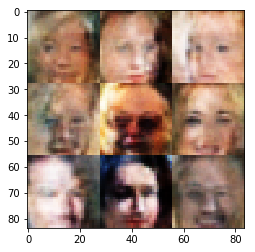

Step: 3810: Epoch 1/1... Discriminator Loss: 0.5854... Generator Loss: 1.7227
Step: 3820: Epoch 1/1... Discriminator Loss: 0.4876... Generator Loss: 2.2789
Step: 3830: Epoch 1/1... Discriminator Loss: 0.5392... Generator Loss: 1.9827
Step: 3840: Epoch 1/1... Discriminator Loss: 0.4242... Generator Loss: 2.9404
Step: 3850: Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 2.2089
Step: 3860: Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.7595
Step: 3870: Epoch 1/1... Discriminator Loss: 1.9547... Generator Loss: 0.3183
Step: 3880: Epoch 1/1... Discriminator Loss: 0.4101... Generator Loss: 3.0455
Step: 3890: Epoch 1/1... Discriminator Loss: 0.5250... Generator Loss: 2.8975
Step: 3900: Epoch 1/1... Discriminator Loss: 0.4137... Generator Loss: 4.6396


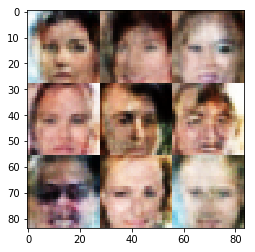

Step: 3910: Epoch 1/1... Discriminator Loss: 0.4967... Generator Loss: 2.0930
Step: 3920: Epoch 1/1... Discriminator Loss: 0.4524... Generator Loss: 2.4581
Step: 3930: Epoch 1/1... Discriminator Loss: 0.7453... Generator Loss: 2.8350
Step: 3940: Epoch 1/1... Discriminator Loss: 0.5202... Generator Loss: 1.9910
Step: 3950: Epoch 1/1... Discriminator Loss: 0.4292... Generator Loss: 3.0836
Step: 3960: Epoch 1/1... Discriminator Loss: 0.4467... Generator Loss: 3.1973
Step: 3970: Epoch 1/1... Discriminator Loss: 0.4126... Generator Loss: 3.2870
Step: 3980: Epoch 1/1... Discriminator Loss: 2.7735... Generator Loss: 0.1397
Step: 3990: Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 1.0698
Step: 4000: Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 1.5551


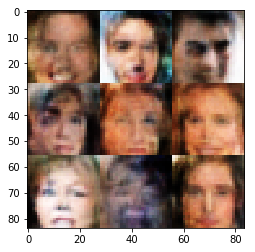

Step: 4010: Epoch 1/1... Discriminator Loss: 1.8225... Generator Loss: 3.6115
Step: 4020: Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.5693
Step: 4030: Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.6098
Step: 4040: Epoch 1/1... Discriminator Loss: 0.6268... Generator Loss: 1.8767
Step: 4050: Epoch 1/1... Discriminator Loss: 0.5923... Generator Loss: 1.5640
Step: 4060: Epoch 1/1... Discriminator Loss: 0.7546... Generator Loss: 1.2603
Step: 4070: Epoch 1/1... Discriminator Loss: 0.7000... Generator Loss: 1.3298
Step: 4080: Epoch 1/1... Discriminator Loss: 0.5067... Generator Loss: 1.9622
Step: 4090: Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 2.8464
Step: 4100: Epoch 1/1... Discriminator Loss: 0.5054... Generator Loss: 2.1949


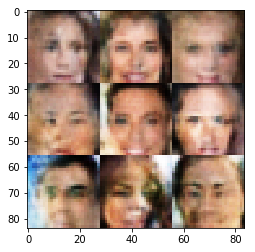

Step: 4110: Epoch 1/1... Discriminator Loss: 0.4113... Generator Loss: 3.1791
Step: 4120: Epoch 1/1... Discriminator Loss: 0.4608... Generator Loss: 2.5019
Step: 4130: Epoch 1/1... Discriminator Loss: 0.6268... Generator Loss: 1.7212
Step: 4140: Epoch 1/1... Discriminator Loss: 0.5575... Generator Loss: 2.4959
Step: 4150: Epoch 1/1... Discriminator Loss: 0.4425... Generator Loss: 3.7097
Step: 4160: Epoch 1/1... Discriminator Loss: 0.4671... Generator Loss: 2.6421
Step: 4170: Epoch 1/1... Discriminator Loss: 0.6733... Generator Loss: 1.4120
Step: 4180: Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 0.9200
Step: 4190: Epoch 1/1... Discriminator Loss: 2.3563... Generator Loss: 4.2714
Step: 4200: Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 2.4309


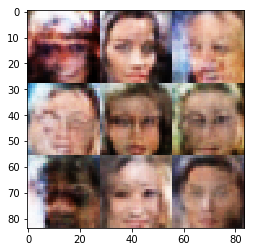

Step: 4210: Epoch 1/1... Discriminator Loss: 0.6734... Generator Loss: 1.7745
Step: 4220: Epoch 1/1... Discriminator Loss: 0.5935... Generator Loss: 2.0581
Step: 4230: Epoch 1/1... Discriminator Loss: 0.6181... Generator Loss: 1.5727
Step: 4240: Epoch 1/1... Discriminator Loss: 0.4927... Generator Loss: 2.2122
Step: 4250: Epoch 1/1... Discriminator Loss: 0.4779... Generator Loss: 2.3640
Step: 4260: Epoch 1/1... Discriminator Loss: 0.5012... Generator Loss: 2.1330
Step: 4270: Epoch 1/1... Discriminator Loss: 0.4307... Generator Loss: 2.6848
Step: 4280: Epoch 1/1... Discriminator Loss: 0.6371... Generator Loss: 1.4841
Step: 4290: Epoch 1/1... Discriminator Loss: 0.4517... Generator Loss: 2.6538
Step: 4300: Epoch 1/1... Discriminator Loss: 0.4416... Generator Loss: 2.7787


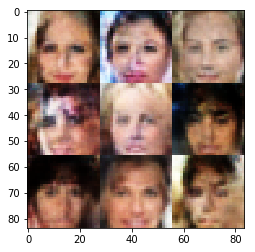

Step: 4310: Epoch 1/1... Discriminator Loss: 0.4016... Generator Loss: 3.8289
Step: 4320: Epoch 1/1... Discriminator Loss: 0.4338... Generator Loss: 2.7955
Step: 4330: Epoch 1/1... Discriminator Loss: 0.4208... Generator Loss: 2.7702
Step: 4340: Epoch 1/1... Discriminator Loss: 0.7228... Generator Loss: 3.8153
Step: 4350: Epoch 1/1... Discriminator Loss: 0.5924... Generator Loss: 1.8903
Step: 4360: Epoch 1/1... Discriminator Loss: 0.4256... Generator Loss: 2.7671
Step: 4370: Epoch 1/1... Discriminator Loss: 0.6573... Generator Loss: 1.4637
Step: 4380: Epoch 1/1... Discriminator Loss: 0.4632... Generator Loss: 2.5707
Step: 4390: Epoch 1/1... Discriminator Loss: 0.3740... Generator Loss: 3.6940
Step: 4400: Epoch 1/1... Discriminator Loss: 0.4971... Generator Loss: 2.4547


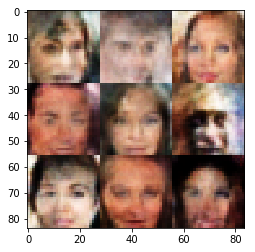

Step: 4410: Epoch 1/1... Discriminator Loss: 0.5024... Generator Loss: 2.3660
Step: 4420: Epoch 1/1... Discriminator Loss: 0.6009... Generator Loss: 3.0956
Step: 4430: Epoch 1/1... Discriminator Loss: 0.3916... Generator Loss: 3.5724
Step: 4440: Epoch 1/1... Discriminator Loss: 0.3617... Generator Loss: 5.6211
Step: 4450: Epoch 1/1... Discriminator Loss: 0.4295... Generator Loss: 3.9799
Step: 4460: Epoch 1/1... Discriminator Loss: 0.6753... Generator Loss: 1.4342
Step: 4470: Epoch 1/1... Discriminator Loss: 0.7306... Generator Loss: 1.3105
Step: 4480: Epoch 1/1... Discriminator Loss: 0.4395... Generator Loss: 2.8190
Step: 4490: Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.6693
Step: 4500: Epoch 1/1... Discriminator Loss: 0.8764... Generator Loss: 1.9569


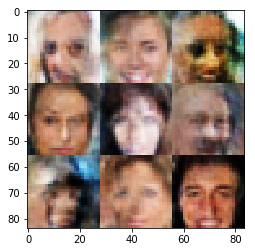

Step: 4510: Epoch 1/1... Discriminator Loss: 2.1687... Generator Loss: 0.2252
Step: 4520: Epoch 1/1... Discriminator Loss: 0.4844... Generator Loss: 2.6213
Step: 4530: Epoch 1/1... Discriminator Loss: 0.4193... Generator Loss: 2.7938
Step: 4540: Epoch 1/1... Discriminator Loss: 0.8297... Generator Loss: 1.1690
Step: 4550: Epoch 1/1... Discriminator Loss: 0.4565... Generator Loss: 2.6347
Step: 4560: Epoch 1/1... Discriminator Loss: 0.4595... Generator Loss: 3.3854
Step: 4570: Epoch 1/1... Discriminator Loss: 2.3479... Generator Loss: 0.2316
Step: 4580: Epoch 1/1... Discriminator Loss: 0.5034... Generator Loss: 2.5846
Step: 4590: Epoch 1/1... Discriminator Loss: 0.7601... Generator Loss: 1.2712
Step: 4600: Epoch 1/1... Discriminator Loss: 0.7453... Generator Loss: 1.3731


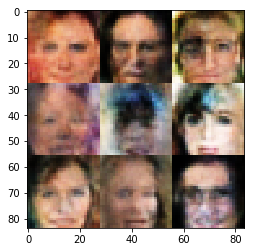

Step: 4610: Epoch 1/1... Discriminator Loss: 0.4761... Generator Loss: 3.2003
Step: 4620: Epoch 1/1... Discriminator Loss: 0.6661... Generator Loss: 1.6509
Step: 4630: Epoch 1/1... Discriminator Loss: 0.6509... Generator Loss: 2.8637
Step: 4640: Epoch 1/1... Discriminator Loss: 0.7240... Generator Loss: 1.3184
Step: 4650: Epoch 1/1... Discriminator Loss: 0.6051... Generator Loss: 1.7132
Step: 4660: Epoch 1/1... Discriminator Loss: 0.8951... Generator Loss: 0.9827
Step: 4670: Epoch 1/1... Discriminator Loss: 0.9807... Generator Loss: 0.9496
Step: 4680: Epoch 1/1... Discriminator Loss: 0.5410... Generator Loss: 2.2380
Step: 4690: Epoch 1/1... Discriminator Loss: 0.5099... Generator Loss: 2.9880
Step: 4700: Epoch 1/1... Discriminator Loss: 0.4103... Generator Loss: 3.3526


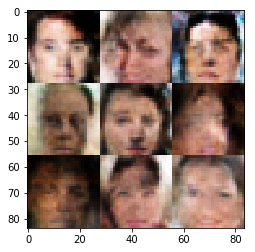

Step: 4710: Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 4.2279
Step: 4720: Epoch 1/1... Discriminator Loss: 0.8214... Generator Loss: 3.2023
Step: 4730: Epoch 1/1... Discriminator Loss: 0.7040... Generator Loss: 1.3847
Step: 4740: Epoch 1/1... Discriminator Loss: 1.5287... Generator Loss: 0.4520
Step: 4750: Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 2.8135
Step: 4760: Epoch 1/1... Discriminator Loss: 0.6167... Generator Loss: 1.6497
Step: 4770: Epoch 1/1... Discriminator Loss: 0.5096... Generator Loss: 2.1737
Step: 4780: Epoch 1/1... Discriminator Loss: 0.5189... Generator Loss: 1.9694
Step: 4790: Epoch 1/1... Discriminator Loss: 0.3719... Generator Loss: 3.5876
Step: 4800: Epoch 1/1... Discriminator Loss: 0.5915... Generator Loss: 1.7407


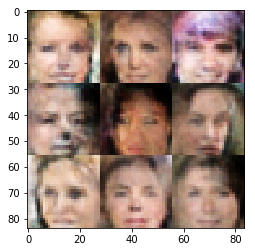

Step: 4810: Epoch 1/1... Discriminator Loss: 2.0095... Generator Loss: 4.6532
Step: 4820: Epoch 1/1... Discriminator Loss: 0.4616... Generator Loss: 2.9781
Step: 4830: Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 0.8463
Step: 4840: Epoch 1/1... Discriminator Loss: 0.6300... Generator Loss: 1.5292
Step: 4850: Epoch 1/1... Discriminator Loss: 0.4957... Generator Loss: 4.1530
Step: 4860: Epoch 1/1... Discriminator Loss: 0.8145... Generator Loss: 1.0844
Step: 4870: Epoch 1/1... Discriminator Loss: 0.4931... Generator Loss: 2.3247
Step: 4880: Epoch 1/1... Discriminator Loss: 1.8729... Generator Loss: 3.9875
Step: 4890: Epoch 1/1... Discriminator Loss: 0.4119... Generator Loss: 3.3889
Step: 4900: Epoch 1/1... Discriminator Loss: 0.5395... Generator Loss: 2.2274


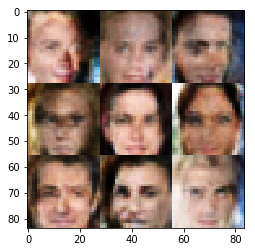

Step: 4910: Epoch 1/1... Discriminator Loss: 0.5539... Generator Loss: 1.8106
Step: 4920: Epoch 1/1... Discriminator Loss: 0.7347... Generator Loss: 1.3357
Step: 4930: Epoch 1/1... Discriminator Loss: 0.4544... Generator Loss: 2.4985
Step: 4940: Epoch 1/1... Discriminator Loss: 0.4125... Generator Loss: 3.0950
Step: 4950: Epoch 1/1... Discriminator Loss: 0.5568... Generator Loss: 2.2234
Step: 4960: Epoch 1/1... Discriminator Loss: 0.4454... Generator Loss: 3.7094
Step: 4970: Epoch 1/1... Discriminator Loss: 0.4377... Generator Loss: 3.6577
Step: 4980: Epoch 1/1... Discriminator Loss: 0.5706... Generator Loss: 1.9307
Step: 4990: Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.7333
Step: 5000: Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 0.8909


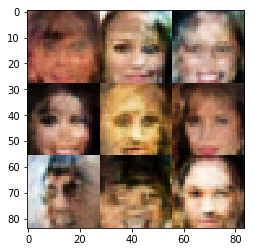

Step: 5010: Epoch 1/1... Discriminator Loss: 0.9058... Generator Loss: 1.1441
Step: 5020: Epoch 1/1... Discriminator Loss: 0.4011... Generator Loss: 3.1571
Step: 5030: Epoch 1/1... Discriminator Loss: 0.4394... Generator Loss: 2.7280
Step: 5040: Epoch 1/1... Discriminator Loss: 0.5555... Generator Loss: 1.9966
Step: 5050: Epoch 1/1... Discriminator Loss: 0.7390... Generator Loss: 1.3519
Step: 5060: Epoch 1/1... Discriminator Loss: 0.5989... Generator Loss: 2.5792
Step: 5070: Epoch 1/1... Discriminator Loss: 0.4148... Generator Loss: 2.9680
Step: 5080: Epoch 1/1... Discriminator Loss: 0.9169... Generator Loss: 0.9307
Step: 5090: Epoch 1/1... Discriminator Loss: 0.3992... Generator Loss: 3.9255
Step: 5100: Epoch 1/1... Discriminator Loss: 0.4017... Generator Loss: 3.0784


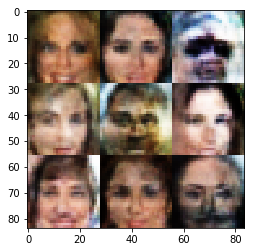

Step: 5110: Epoch 1/1... Discriminator Loss: 0.4227... Generator Loss: 3.1422
Step: 5120: Epoch 1/1... Discriminator Loss: 0.9709... Generator Loss: 0.8860
Step: 5130: Epoch 1/1... Discriminator Loss: 0.4800... Generator Loss: 2.2325
Step: 5140: Epoch 1/1... Discriminator Loss: 0.6337... Generator Loss: 1.5463
Step: 5150: Epoch 1/1... Discriminator Loss: 0.5084... Generator Loss: 1.9930
Step: 5160: Epoch 1/1... Discriminator Loss: 0.5861... Generator Loss: 1.6605
Step: 5170: Epoch 1/1... Discriminator Loss: 0.4758... Generator Loss: 3.3630
Step: 5180: Epoch 1/1... Discriminator Loss: 0.5474... Generator Loss: 1.8569
Step: 5190: Epoch 1/1... Discriminator Loss: 0.4107... Generator Loss: 2.8529
Step: 5200: Epoch 1/1... Discriminator Loss: 0.3862... Generator Loss: 3.4280


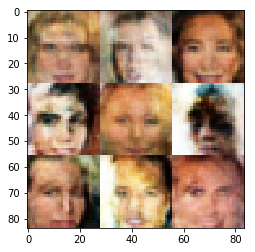

Step: 5210: Epoch 1/1... Discriminator Loss: 1.6689... Generator Loss: 0.4416
Step: 5220: Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.6802
Step: 5230: Epoch 1/1... Discriminator Loss: 0.3710... Generator Loss: 5.4387
Step: 5240: Epoch 1/1... Discriminator Loss: 0.7295... Generator Loss: 1.3995
Step: 5250: Epoch 1/1... Discriminator Loss: 0.3975... Generator Loss: 3.9805
Step: 5260: Epoch 1/1... Discriminator Loss: 0.3865... Generator Loss: 4.2895
Step: 5270: Epoch 1/1... Discriminator Loss: 0.4644... Generator Loss: 3.3532
Step: 5280: Epoch 1/1... Discriminator Loss: 0.6274... Generator Loss: 3.8156
Step: 5290: Epoch 1/1... Discriminator Loss: 0.3858... Generator Loss: 3.5811
Step: 5300: Epoch 1/1... Discriminator Loss: 0.5113... Generator Loss: 2.2546


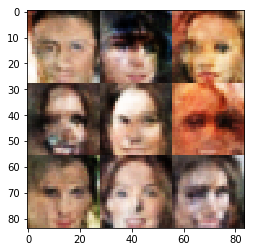

Step: 5310: Epoch 1/1... Discriminator Loss: 2.7165... Generator Loss: 5.6082
Step: 5320: Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 1.3917
Step: 5330: Epoch 1/1... Discriminator Loss: 0.8980... Generator Loss: 1.1092
Step: 5340: Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.5373
Step: 5350: Epoch 1/1... Discriminator Loss: 0.5620... Generator Loss: 1.7701
Step: 5360: Epoch 1/1... Discriminator Loss: 0.5361... Generator Loss: 2.1695
Step: 5370: Epoch 1/1... Discriminator Loss: 0.5798... Generator Loss: 1.7854
Step: 5380: Epoch 1/1... Discriminator Loss: 0.3906... Generator Loss: 3.6089
Step: 5390: Epoch 1/1... Discriminator Loss: 0.5954... Generator Loss: 1.6301
Step: 5400: Epoch 1/1... Discriminator Loss: 0.6815... Generator Loss: 1.4343


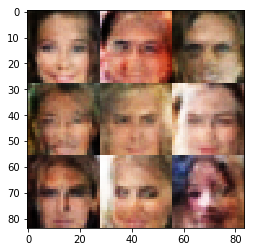

Step: 5410: Epoch 1/1... Discriminator Loss: 0.4193... Generator Loss: 2.9229
Step: 5420: Epoch 1/1... Discriminator Loss: 0.4441... Generator Loss: 2.5083
Step: 5430: Epoch 1/1... Discriminator Loss: 0.7912... Generator Loss: 1.3168
Step: 5440: Epoch 1/1... Discriminator Loss: 0.4579... Generator Loss: 2.4495
Step: 5450: Epoch 1/1... Discriminator Loss: 0.4381... Generator Loss: 2.5456
Step: 5460: Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 4.3058
Step: 5470: Epoch 1/1... Discriminator Loss: 0.3872... Generator Loss: 3.7573
Step: 5480: Epoch 1/1... Discriminator Loss: 0.4463... Generator Loss: 2.4761
Step: 5490: Epoch 1/1... Discriminator Loss: 0.4083... Generator Loss: 3.2181
Step: 5500: Epoch 1/1... Discriminator Loss: 2.0905... Generator Loss: 4.2552


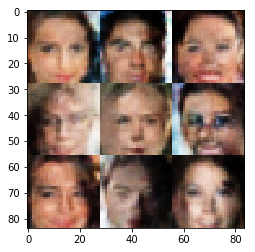

Step: 5510: Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 4.0359
Step: 5520: Epoch 1/1... Discriminator Loss: 0.6419... Generator Loss: 1.9586
Step: 5530: Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 1.9815
Step: 5540: Epoch 1/1... Discriminator Loss: 0.5471... Generator Loss: 1.7943
Step: 5550: Epoch 1/1... Discriminator Loss: 0.7603... Generator Loss: 3.2246
Step: 5560: Epoch 1/1... Discriminator Loss: 0.5844... Generator Loss: 1.8745
Step: 5570: Epoch 1/1... Discriminator Loss: 0.5325... Generator Loss: 3.1562
Step: 5580: Epoch 1/1... Discriminator Loss: 0.4530... Generator Loss: 2.7856
Step: 5590: Epoch 1/1... Discriminator Loss: 0.4707... Generator Loss: 2.3236
Step: 5600: Epoch 1/1... Discriminator Loss: 0.4091... Generator Loss: 2.9889


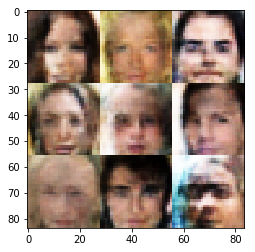

Step: 5610: Epoch 1/1... Discriminator Loss: 0.5233... Generator Loss: 2.0340
Step: 5620: Epoch 1/1... Discriminator Loss: 0.6532... Generator Loss: 1.4377
Step: 5630: Epoch 1/1... Discriminator Loss: 0.5883... Generator Loss: 1.9527
Step: 5640: Epoch 1/1... Discriminator Loss: 0.3591... Generator Loss: 4.7135
Step: 5650: Epoch 1/1... Discriminator Loss: 0.5787... Generator Loss: 1.7796
Step: 5660: Epoch 1/1... Discriminator Loss: 0.5777... Generator Loss: 1.7093
Step: 5670: Epoch 1/1... Discriminator Loss: 0.4732... Generator Loss: 2.2203
Step: 5680: Epoch 1/1... Discriminator Loss: 0.4386... Generator Loss: 2.5837
Step: 5690: Epoch 1/1... Discriminator Loss: 0.4388... Generator Loss: 2.6192
Step: 5700: Epoch 1/1... Discriminator Loss: 0.5513... Generator Loss: 1.8258


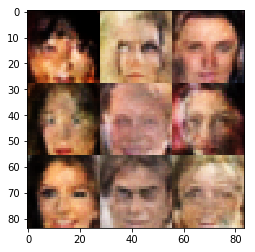

Step: 5710: Epoch 1/1... Discriminator Loss: 0.6079... Generator Loss: 1.8982
Step: 5720: Epoch 1/1... Discriminator Loss: 0.9601... Generator Loss: 1.1734
Step: 5730: Epoch 1/1... Discriminator Loss: 0.5174... Generator Loss: 2.3291
Step: 5740: Epoch 1/1... Discriminator Loss: 0.6599... Generator Loss: 1.6202
Step: 5750: Epoch 1/1... Discriminator Loss: 0.4456... Generator Loss: 2.5211
Step: 5760: Epoch 1/1... Discriminator Loss: 0.4650... Generator Loss: 2.3131
Step: 5770: Epoch 1/1... Discriminator Loss: 0.6779... Generator Loss: 1.5369
Step: 5780: Epoch 1/1... Discriminator Loss: 0.6122... Generator Loss: 1.7801
Step: 5790: Epoch 1/1... Discriminator Loss: 0.3947... Generator Loss: 3.2180
Step: 5800: Epoch 1/1... Discriminator Loss: 0.6780... Generator Loss: 1.4643


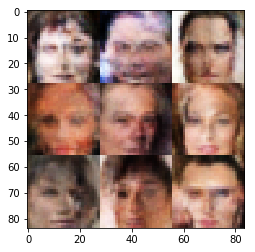

Step: 5810: Epoch 1/1... Discriminator Loss: 0.5238... Generator Loss: 1.9675
Step: 5820: Epoch 1/1... Discriminator Loss: 0.7139... Generator Loss: 1.6075
Step: 5830: Epoch 1/1... Discriminator Loss: 2.6652... Generator Loss: 0.1618
Step: 5840: Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.7158
Step: 5850: Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 3.7991
Step: 5860: Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.5264
Step: 5870: Epoch 1/1... Discriminator Loss: 0.4876... Generator Loss: 2.8433
Step: 5880: Epoch 1/1... Discriminator Loss: 0.3990... Generator Loss: 4.1374
Step: 5890: Epoch 1/1... Discriminator Loss: 0.8113... Generator Loss: 1.1929
Step: 5900: Epoch 1/1... Discriminator Loss: 0.6444... Generator Loss: 1.5010


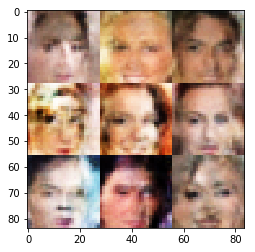

Step: 5910: Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.7077
Step: 5920: Epoch 1/1... Discriminator Loss: 0.6187... Generator Loss: 1.6682
Step: 5930: Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 3.6197
Step: 5940: Epoch 1/1... Discriminator Loss: 0.5904... Generator Loss: 1.6546
Step: 5950: Epoch 1/1... Discriminator Loss: 0.4371... Generator Loss: 2.7614
Step: 5960: Epoch 1/1... Discriminator Loss: 0.5691... Generator Loss: 1.8613
Step: 5970: Epoch 1/1... Discriminator Loss: 0.3734... Generator Loss: 4.3812
Step: 5980: Epoch 1/1... Discriminator Loss: 0.4457... Generator Loss: 2.5335
Step: 5990: Epoch 1/1... Discriminator Loss: 0.4942... Generator Loss: 2.0350
Step: 6000: Epoch 1/1... Discriminator Loss: 0.6143... Generator Loss: 1.8267


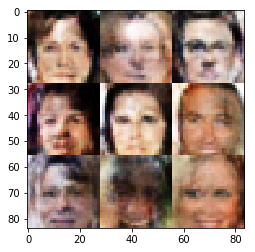

Step: 6010: Epoch 1/1... Discriminator Loss: 0.4818... Generator Loss: 2.2183
Step: 6020: Epoch 1/1... Discriminator Loss: 0.5682... Generator Loss: 2.8626
Step: 6030: Epoch 1/1... Discriminator Loss: 0.3965... Generator Loss: 3.4801
Step: 6040: Epoch 1/1... Discriminator Loss: 0.5893... Generator Loss: 2.8282
Step: 6050: Epoch 1/1... Discriminator Loss: 0.5417... Generator Loss: 2.5338
Step: 6060: Epoch 1/1... Discriminator Loss: 0.4546... Generator Loss: 2.7914
Step: 6070: Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.8420
Step: 6080: Epoch 1/1... Discriminator Loss: 1.7611... Generator Loss: 0.3518
Step: 6090: Epoch 1/1... Discriminator Loss: 0.4983... Generator Loss: 2.2121
Step: 6100: Epoch 1/1... Discriminator Loss: 0.4776... Generator Loss: 3.6337


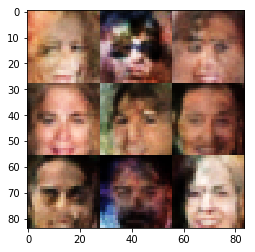

Step: 6110: Epoch 1/1... Discriminator Loss: 0.5052... Generator Loss: 2.1484
Step: 6120: Epoch 1/1... Discriminator Loss: 0.7270... Generator Loss: 2.2099
Step: 6130: Epoch 1/1... Discriminator Loss: 0.4633... Generator Loss: 2.3157
Step: 6140: Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.6006
Step: 6150: Epoch 1/1... Discriminator Loss: 0.6725... Generator Loss: 1.5291
Step: 6160: Epoch 1/1... Discriminator Loss: 1.9855... Generator Loss: 4.4860
Step: 6170: Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.7745
Step: 6180: Epoch 1/1... Discriminator Loss: 0.4075... Generator Loss: 3.3075
Step: 6190: Epoch 1/1... Discriminator Loss: 0.7437... Generator Loss: 1.2902
Step: 6200: Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.6182


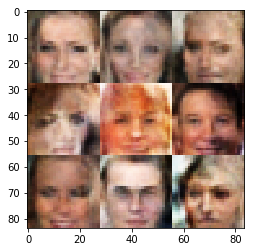

Step: 6210: Epoch 1/1... Discriminator Loss: 0.4145... Generator Loss: 3.2460
Step: 6220: Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.6124
Step: 6230: Epoch 1/1... Discriminator Loss: 0.3689... Generator Loss: 4.4499
Step: 6240: Epoch 1/1... Discriminator Loss: 0.3874... Generator Loss: 3.5912
Step: 6250: Epoch 1/1... Discriminator Loss: 0.4339... Generator Loss: 3.4198
Step: 6260: Epoch 1/1... Discriminator Loss: 0.4384... Generator Loss: 3.7253
Step: 6270: Epoch 1/1... Discriminator Loss: 0.4217... Generator Loss: 2.7963
Step: 6280: Epoch 1/1... Discriminator Loss: 0.4822... Generator Loss: 2.2237
Step: 6290: Epoch 1/1... Discriminator Loss: 0.4732... Generator Loss: 2.8239
Step: 6300: Epoch 1/1... Discriminator Loss: 0.3779... Generator Loss: 3.5107


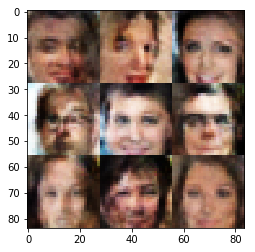

Step: 6310: Epoch 1/1... Discriminator Loss: 0.4990... Generator Loss: 2.1486
Step: 6320: Epoch 1/1... Discriminator Loss: 0.4640... Generator Loss: 3.4547
Step: 6330: Epoch 1/1... Discriminator Loss: 0.4127... Generator Loss: 3.0255
Finished with trainning


In [32]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.